In [2]:
import wandb
api = wandb.Api()

# Just load seaborn & set theme and the chart looks better:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

# set matplotlib dpi to 200 to make the images bigger
plt.rcParams['figure.dpi'] = 200
wandb_cache = {}

In [3]:
metric_map = {"base": "Top1", "topk": "Top10", "skip": "Skip50-Top1", "topk_skip": "Skip50-Top10", "loss": "Loss", "perplexity": "Perplexity"}

def is_loss_metric(metric_name):
    if metric_name == "perplexity":
        return True
    if metric_name[-4:] == "loss":
        return True
    return False

def get_data(h, dataset, key):
    if key == "perplexity":
        arr = np.array([ float(x) for x in h[f"loss_data/{dataset}/loss"]])
        if np.isnan(arr[0]):
            return np.ones_like(arr)
        return np.exp(arr)
    if is_loss_metric(key):
        arr = np.array([ float(x) for x in h[f"loss_data/{dataset}/{key}"]])
        if np.isnan(arr[0]):
            return np.ones_like(arr)
        return arr
    return h[f"accuracy/{dataset}/{key}"]

def get_data_normed(h, dataset, key):
    arr = get_data(h, dataset, key)
    return arr/arr[0]

def get(h, dataset, key, normed=False):
    if normed:
        return get_data_normed(h, dataset, key)
    return get_data(h, dataset, key)

class WandbRunData:
    def __init__(self, run_name):
        self.run_name = run_name.split("https://wandb.ai/")[-1]

        if self.run_name in wandb_cache:
            self.run = wandb_cache[run_name]
        else:
            self.run = api.run(self.run_name)
            wandb_cache[run_name] = self.run

        self.history = self.run.history()
        self.h = self.history
        c = self.run.config

        self.model_name = c["model_size"].split("/")[-1].lower()

        max_frac = max( c["ff_frac"], c["attn_frac"] )
        self.frac = self.history["_step"] * max_frac

        self.cripple, self.focus = c["cripple"], c["focus"]
        self.cripple_label = self.cripple
        self.focus_label   = self.focus

        # Get "unique" names
        self.name_set = self.focus_label + " " + self.cripple_label
        self.name_set_model = self.name_set + " " + self.model_name

    def get_metric(self, metric):
        if is_loss_metric(metric):
            return self.get_loss_metric(metric)
        return self.get_d_metric(metric)

    def get_d_metric(self, metric):
        self.scale = 100
        focus_perf     = get_data(self.h, self.focus,   metric) * self.scale
        cripple_perf   = get_data(self.h, self.cripple, metric) * self.scale
        return focus_perf, cripple_perf


def plot_frac_pruned(run_obj, metric, **kwargs):
    r = run_obj
    focus_perf   = get_data(r.h, r.focus, metric)
    metric_name = metric_map[metric]

    # Begin plotting
    plt.plot(r.frac*100, focus_perf, **kwargs)

    print(list(zip(r.frac, focus_perf)))

    # Add details
    plt.xlim(-0.01, 100)
    plt.ylim(-0.01, None)
    plt.xlabel("% Attention Neurons Pruned")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} ({r.model_name})")
    plt.legend()

def latex_data(datas, idx1 = 5, idx2 = -2, fmt = "%.2f", fmt_e="%.2f\pm%.2f"):
    datas = np.array(datas)
    accs_0 = datas[0,    0,  1]
    accs_1 = datas[:, idx1, -1]
    accs_2 = datas[:, idx2, -1]

    printxx = lambda arr : print([fmt%f for x in arr])
    getxe   = lambda arr, errarr : [fmt_e %(x,e) for x,e in zip(arr, errarr)]

    data0 = [f"{accs_0:2.2f}"]
    data1 = getxe( accs_1.reshape(-1, 3).mean(axis=-1), accs_1.reshape(-1, 3).std(axis=-1) )
    data2 = getxe( accs_2.reshape(-1, 3).mean(axis=-1), accs_2.reshape(-1, 3).std(axis=-1) )
    both_data = np.array([data1, data2])
    print(data0[0])
    print(" & ".join(data1))
    print(" & ".join(data2))
    # print(" & ".join([ *data0, *both_data.flatten() ]))

[(0.0, 2.2358), (0.05, 2.254), (0.1, 2.2953), (0.15000000000000002, 2.3485), (0.2, 2.4054), (0.25, 2.485), (0.30000000000000004, 2.6185), (0.35000000000000003, 3.0158), (0.4, 3.3763), (0.45, 3.8323), (0.5, 4.5068), (0.55, 5.0899), (0.6000000000000001, 5.515), (0.65, 5.8328), (0.7000000000000001, 6.092), (0.75, 6.4784), (0.8, 7.0957), (0.8500000000000001, 7.9866), (0.9, 8.6174), (0.9500000000000001, 9.6841), (1.0, 10.5976)]
[(0.0, 2.2358), (0.05, 2.258), (0.1, 2.3012), (0.15000000000000002, 2.3376), (0.2, 2.3931), (0.25, 2.4651), (0.30000000000000004, 2.5921), (0.35000000000000003, 2.7688), (0.4, 3.042), (0.45, 3.57), (0.5, 4.3002), (0.55, 4.7479), (0.6000000000000001, 5.1451), (0.65, 5.6763), (0.7000000000000001, 6.1961), (0.75, 6.5369), (0.8, 7.1331), (0.8500000000000001, 7.5523), (0.9, 8.2898), (0.9500000000000001, 9.8136), (1.0, 10.56)]


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


[(0.0, 2.2358), (0.05, 2.2599), (0.1, 2.2957), (0.15000000000000002, 2.3453), (0.2, 2.4014), (0.25, 2.4831), (0.30000000000000004, 2.7953), (0.35000000000000003, 3.0829), (0.4, 3.7342), (0.45, 4.2537), (0.5, 4.793), (0.55, 5.1399), (0.6000000000000001, 5.471), (0.65, 5.8259), (0.7000000000000001, 6.1176), (0.75, 6.4942), (0.8, 6.8433), (0.8500000000000001, 7.4206), (0.9, 8.2883), (0.9500000000000001, 9.1637), (1.0, 10.3755)]
[(0.0, 2.2358), (0.05, 2.265), (0.1, 2.3053), (0.15000000000000002, 2.3649), (0.2, 2.4422), (0.25, 2.578), (0.30000000000000004, 2.7561), (0.35000000000000003, 3.0635), (0.4, 3.4376), (0.45, 4.2524), (0.5, 4.9683), (0.55, 5.6685), (0.6000000000000001, 6.3459), (0.65, 6.7216), (0.7000000000000001, 6.98), (0.75, 7.3847), (0.8, 7.5241), (0.8500000000000001, 7.6205), (0.9, 7.8719), (0.9500000000000001, 8.028), (1.0, 8.1614)]
[(0.0, 2.2358), (0.05, 2.2634), (0.1, 2.2971), (0.15000000000000002, 2.36), (0.2, 2.4293), (0.25, 2.5369), (0.30000000000000004, 2.6924), (0.35000

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


[(0.0, 2.2358), (0.05, 2.2621), (0.1, 2.2958), (0.15000000000000002, 2.3482), (0.2, 2.4104), (0.25, 2.4999), (0.30000000000000004, 2.6605), (0.35000000000000003, 2.9392), (0.4, 3.2892), (0.45, 3.8431), (0.5, 4.4435), (0.55, 5.1471), (0.6000000000000001, 5.7768), (0.65, 6.4279), (0.7000000000000001, 6.8968), (0.75, 7.3435), (0.8, 7.757), (0.8500000000000001, 8.2889), (0.9, 8.7479), (0.9500000000000001, 9.0264), (1.0, 9.283)]


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


[(0.0, 2.2358), (0.05, 2.2496), (0.1, 2.2681), (0.15000000000000002, 2.289), (0.2, 2.3182), (0.25, 2.3574), (0.30000000000000004, 2.4031), (0.35000000000000003, 2.4635), (0.4, 2.5518), (0.45, 2.7018), (0.5, 2.9092), (0.55, 3.2181), (0.6000000000000001, 3.7621), (0.65, 4.1237), (0.7000000000000001, 4.5222), (0.75, 4.9223), (0.8, 5.3697), (0.8500000000000001, 5.8242), (0.9, 6.2855), (0.9500000000000001, 6.7524), (1.0, 7.2436)]
[(0.0, 2.2358), (0.05, 2.2512), (0.1, 2.2668), (0.15000000000000002, 2.2878), (0.2, 2.3227), (0.25, 2.3621), (0.30000000000000004, 2.4168), (0.35000000000000003, 2.4984), (0.4, 2.6046), (0.45, 2.7333), (0.5, 2.9362), (0.55, 3.1815), (0.6000000000000001, 3.6359), (0.65, 4.0678), (0.7000000000000001, 4.5282), (0.75, 4.978), (0.8, 5.4804), (0.8500000000000001, 5.9245), (0.9, 6.322), (0.9500000000000001, 6.7501), (1.0, 7.1994)]
[(0.0, 2.2358), (0.05, 2.2486), (0.1, 2.2677), (0.15000000000000002, 2.2899), (0.2, 2.318), (0.25, 2.3595), (0.30000000000000004, 2.4163), (0.3

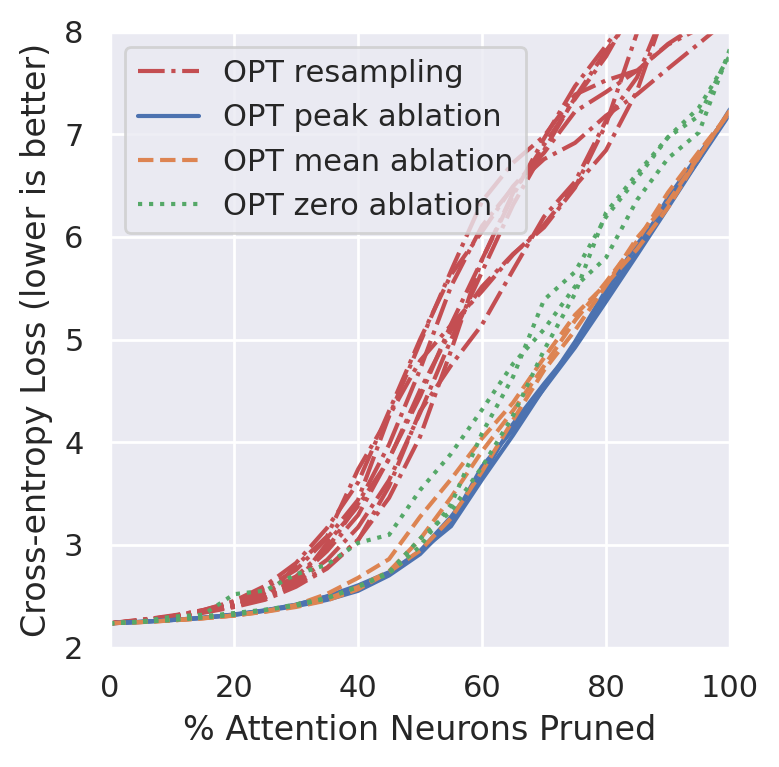

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


[(0.0, 55.045609808288226), (0.05, 54.70878672362279), (0.1, 54.200778259456804), (0.15000000000000002, 53.36228690986614), (0.2, 52.488924464451294), (0.25, 51.24466036345192), (0.30000000000000004, 49.24591255280197), (0.35000000000000003, 43.52784536254052), (0.4, 38.80677450288875), (0.45, 33.47149684178825), (0.5, 26.40375973814977), (0.55, 20.22682062783823), (0.6000000000000001, 16.104898596438392), (0.65, 13.870770888975185), (0.7000000000000001, 12.394296990782935), (0.75, 10.517598015517638), (0.8, 8.73203940433828), (0.8500000000000001, 6.44798262785408), (0.9, 5.601566029212468), (0.9500000000000001, 4.300240135046244), (1.0, 3.576664896694379)]
[(0.0, 55.045609808288226), (0.05, 54.754753168118306), (0.1, 54.13341364252371), (0.15000000000000002, 53.58974155762845), (0.2, 52.733814660125695), (0.25, 51.66469856315235), (0.30000000000000004, 49.77611171431062), (0.35000000000000003, 47.34068268095325), (0.4, 43.52863788744561), (0.45, 36.726396627014005), (0.5, 28.469872165

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


[(0.0, 55.045609808288226), (0.05, 54.60258838634004), (0.1, 54.069219125211006), (0.15000000000000002, 53.47086282186418), (0.2, 52.71479406240341), (0.25, 51.57672829868679), (0.30000000000000004, 49.682593775509396), (0.35000000000000003, 47.58953550115312), (0.4, 44.13650448965359), (0.45, 39.0437394495122), (0.5, 32.0774455337259), (0.55, 23.89779598823893), (0.6000000000000001, 17.015509712392713), (0.65, 13.098851631412517), (0.7000000000000001, 10.464498846876262), (0.75, 8.267619809952528), (0.8, 7.242092582759414), (0.8500000000000001, 6.1943746582236345), (0.9, 5.481102243638007), (0.9500000000000001, 4.903351587823647), (1.0, 4.424666545146181)]
[(0.0, 55.045609808288226), (0.05, 54.51541064677958), (0.1, 54.035933079197015), (0.15000000000000002, 53.47244787167437), (0.2, 52.710831437877935), (0.25, 51.46418976216328), (0.30000000000000004, 49.60413380990498), (0.35000000000000003, 46.518041829464494), (0.4, 42.408800196546174), (0.45, 36.67963765761339), (0.5, 29.53819573

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


[(0.0, 55.05195000752899), (0.05, 54.815777585810636), (0.1, 54.497182573962384), (0.15000000000000002, 54.21662875755871), (0.2, 53.734773615260856), (0.25, 53.17842113188407), (0.30000000000000004, 52.34547745662908), (0.35000000000000003, 51.02988611417114), (0.4, 49.6001711853795), (0.45, 47.617273872831454), (0.5, 44.371884386466846), (0.55, 39.8600401017602), (0.6000000000000001, 34.90279682039008), (0.65, 28.946972158600083), (0.7000000000000001, 24.98276258331418), (0.75, 21.524976422384075), (0.8, 17.559974322193074), (0.8500000000000001, 15.122167714120415), (0.9, 12.762028546747082), (0.9500000000000001, 11.03115415401929), (1.0, 9.805910650742199)]
[(0.0, 55.05195000752899), (0.05, 54.83479818353292), (0.1, 54.606551010865516), (0.15000000000000002, 54.29112609863765), (0.2, 53.862370124981176), (0.25, 53.26559887144454), (0.30000000000000004, 52.61018077493085), (0.35000000000000003, 51.62903494242307), (0.4, 50.06538330467035), (0.45, 47.450051117856376), (0.5, 44.2545907

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


CommError: HTTPSConnectionPool(host='api.wandb.ai', port=443): Read timed out. (read timeout=9)

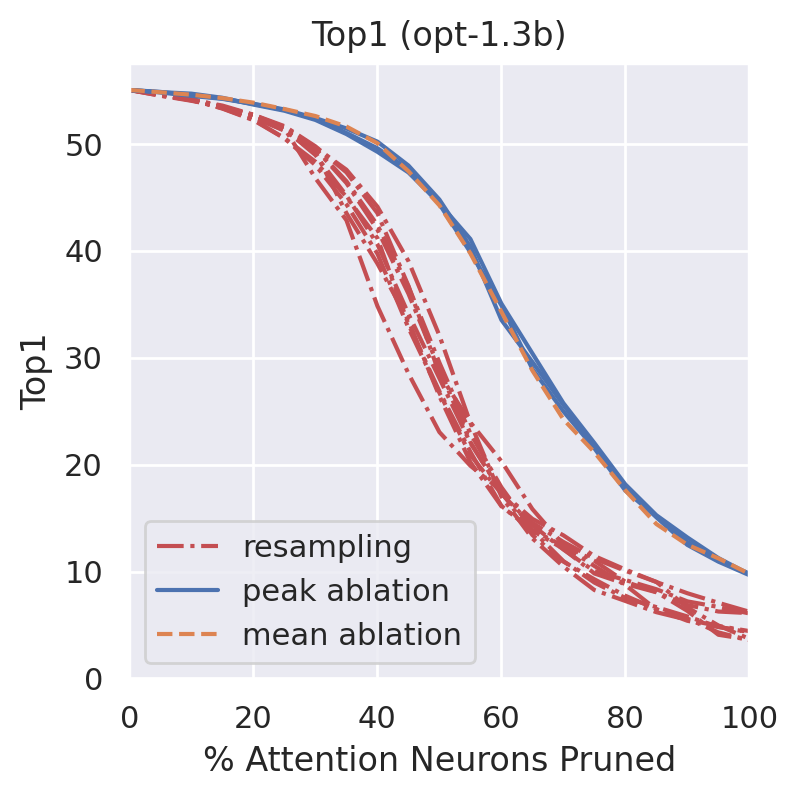

In [ ]:
zero_runs = [
    "https://wandb.ai/seperability/skylar-tests/runs/0uynp8jh",
    "https://wandb.ai/seperability/skylar-tests/runs/65mutlai",
    "https://wandb.ai/seperability/skylar-tests/runs/0yzipie6",
]

peak_runs = [
    "https://wandb.ai/seperability/skylar-tests/runs/7w75etyv",
    "https://wandb.ai/seperability/skylar-tests/runs/oq6dm1hg",
    "https://wandb.ai/seperability/skylar-tests/runs/3y0c2bpo",
]

mean_runs = [
    "https://wandb.ai/seperability/skylar-tests/runs/rkdciwru",
    "https://wandb.ai/seperability/skylar-tests/runs/x08q40mt",
    "https://wandb.ai/seperability/skylar-tests/runs/f89crwxn",
]

resampling_runs = [
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/vym906gg", # chars
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/fzslaasi",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/0xuqkgl6",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/gbx72pqm", # ids
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/svdxk3dd",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/7xvhv1et",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/f2c5u5aq", # gen
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/qgfx1vv1",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/emvl6tz3"
]

plt.figure(figsize=(4,4))
metric = "loss"
for i, x in enumerate(resampling_runs):
    label = "OPT resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
for i, x in enumerate(peak_runs):
    label = "OPT peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "OPT mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "OPT zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
plt.ylim(2, 8)
plt.ylabel("Cross-entropy Loss (lower is better)")
plt.title("")
plt.show()

plt.figure(figsize=(4,4))
metric = "base"
for i, x in enumerate(resampling_runs):
    label = "resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
for i, x in enumerate(peak_runs):
    label = "peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
plt.ylim(None, None)
plt.ylabel("Top1 Accuracy (%)")
plt.title("")
plt.show()

In [28]:
datas_opt_loss = [
[(0.0, 2.2358), (0.05, 2.254), (0.1, 2.2953), (0.15000000000000002, 2.3485), (0.2, 2.4054), (0.25, 2.485), (0.30000000000000004, 2.6185), (0.35000000000000003, 3.0158), (0.4, 3.3763), (0.45, 3.8323), (0.5, 4.5068), (0.55, 5.0899), (0.6000000000000001, 5.515), (0.65, 5.8328), (0.7000000000000001, 6.092), (0.75, 6.4784), (0.8, 7.0957), (0.8500000000000001, 7.9866), (0.9, 8.6174), (0.9500000000000001, 9.6841), (1.0, 10.5976)],
[(0.0, 2.2358), (0.05, 2.258), (0.1, 2.3012), (0.15000000000000002, 2.3376), (0.2, 2.3931), (0.25, 2.4651), (0.30000000000000004, 2.5921), (0.35000000000000003, 2.7688), (0.4, 3.042), (0.45, 3.57), (0.5, 4.3002), (0.55, 4.7479), (0.6000000000000001, 5.1451), (0.65, 5.6763), (0.7000000000000001, 6.1961), (0.75, 6.5369), (0.8, 7.1331), (0.8500000000000001, 7.5523), (0.9, 8.2898), (0.9500000000000001, 9.8136), (1.0, 10.56)],
[(0.0, 2.2358), (0.05, 2.2599), (0.1, 2.2957), (0.15000000000000002, 2.3453), (0.2, 2.4014), (0.25, 2.4831), (0.30000000000000004, 2.7953), (0.35000000000000003, 3.0829), (0.4, 3.7342), (0.45, 4.2537), (0.5, 4.793), (0.55, 5.1399), (0.6000000000000001, 5.471), (0.65, 5.8259), (0.7000000000000001, 6.1176), (0.75, 6.4942), (0.8, 6.8433), (0.8500000000000001, 7.4206), (0.9, 8.2883), (0.9500000000000001, 9.1637), (1.0, 10.3755)],
[(0.0, 2.2358), (0.05, 2.265), (0.1, 2.3053), (0.15000000000000002, 2.3649), (0.2, 2.4422), (0.25, 2.578), (0.30000000000000004, 2.7561), (0.35000000000000003, 3.0635), (0.4, 3.4376), (0.45, 4.2524), (0.5, 4.9683), (0.55, 5.6685), (0.6000000000000001, 6.3459), (0.65, 6.7216), (0.7000000000000001, 6.98), (0.75, 7.3847), (0.8, 7.5241), (0.8500000000000001, 7.6205), (0.9, 7.8719), (0.9500000000000001, 8.028), (1.0, 8.1614)],
[(0.0, 2.2358), (0.05, 2.2634), (0.1, 2.2971), (0.15000000000000002, 2.36), (0.2, 2.4293), (0.25, 2.5369), (0.30000000000000004, 2.6924), (0.35000000000000003, 2.9621), (0.4, 3.3973), (0.45, 3.9768), (0.5, 4.7066), (0.55, 5.5185), (0.6000000000000001, 6.1061), (0.65, 6.4811), (0.7000000000000001, 6.7567), (0.75, 6.9152), (0.8, 7.1805), (0.8500000000000001, 7.3878), (0.9, 7.6382), (0.9500000000000001, 7.8833), (1.0, 8.133)],
[(0.0, 2.2358), (0.05, 2.2609), (0.1, 2.304), (0.15000000000000002, 2.3631), (0.2, 2.4531), (0.25, 2.6001), (0.30000000000000004, 2.8229), (0.35000000000000003, 3.1649), (0.4, 3.6072), (0.45, 4.3017), (0.5, 5.0004), (0.55, 5.6313), (0.6000000000000001, 6.0511), (0.65, 6.4916), (0.7000000000000001, 6.8182), (0.75, 7.22), (0.8, 7.4107), (0.8500000000000001, 7.6185), (0.9, 7.8792), (0.9500000000000001, 8.0741), (1.0, 8.1716)],
[(0.0, 2.2358), (0.05, 2.2721), (0.1, 2.3009), (0.15000000000000002, 2.3505), (0.2, 2.4098), (0.25, 2.4907), (0.30000000000000004, 2.6173), (0.35000000000000003, 2.7783), (0.4, 3.0496), (0.45, 3.457), (0.5, 4.0525), (0.55, 4.8905), (0.6000000000000001, 5.7804), (0.65, 6.4007), (0.7000000000000001, 6.9577), (0.75, 7.4676), (0.8, 7.8623), (0.8500000000000001, 8.2741), (0.9, 8.7182), (0.9500000000000001, 9.0204), (1.0, 9.2562)],
[(0.0, 2.2358), (0.05, 2.2676), (0.1, 2.3113), (0.15000000000000002, 2.3564), (0.2, 2.415), (0.25, 2.5003), (0.30000000000000004, 2.6359), (0.35000000000000003, 2.8537), (0.4, 3.1705), (0.45, 3.6295), (0.5, 4.2839), (0.55, 4.999), (0.6000000000000001, 5.66), (0.65, 6.3117), (0.7000000000000001, 6.8428), (0.75, 7.3561), (0.8, 7.8122), (0.8500000000000001, 8.2139), (0.9, 8.5509), (0.9500000000000001, 8.9737), (1.0, 9.288)],
[(0.0, 2.2358), (0.05, 2.2621), (0.1, 2.2958), (0.15000000000000002, 2.3482), (0.2, 2.4104), (0.25, 2.4999), (0.30000000000000004, 2.6605), (0.35000000000000003, 2.9392), (0.4, 3.2892), (0.45, 3.8431), (0.5, 4.4435), (0.55, 5.1471), (0.6000000000000001, 5.7768), (0.65, 6.4279), (0.7000000000000001, 6.8968), (0.75, 7.3435), (0.8, 7.757), (0.8500000000000001, 8.2889), (0.9, 8.7479), (0.9500000000000001, 9.0264), (1.0, 9.283)],
[(0.0, 2.2358), (0.05, 2.2496), (0.1, 2.2681), (0.15000000000000002, 2.289), (0.2, 2.3182), (0.25, 2.3574), (0.30000000000000004, 2.4031), (0.35000000000000003, 2.4635), (0.4, 2.5518), (0.45, 2.7018), (0.5, 2.9092), (0.55, 3.2181), (0.6000000000000001, 3.7621), (0.65, 4.1237), (0.7000000000000001, 4.5222), (0.75, 4.9223), (0.8, 5.3697), (0.8500000000000001, 5.8242), (0.9, 6.2855), (0.9500000000000001, 6.7524), (1.0, 7.2436)],
[(0.0, 2.2358), (0.05, 2.2512), (0.1, 2.2668), (0.15000000000000002, 2.2878), (0.2, 2.3227), (0.25, 2.3621), (0.30000000000000004, 2.4168), (0.35000000000000003, 2.4984), (0.4, 2.6046), (0.45, 2.7333), (0.5, 2.9362), (0.55, 3.1815), (0.6000000000000001, 3.6359), (0.65, 4.0678), (0.7000000000000001, 4.5282), (0.75, 4.978), (0.8, 5.4804), (0.8500000000000001, 5.9245), (0.9, 6.322), (0.9500000000000001, 6.7501), (1.0, 7.1994)],
[(0.0, 2.2358), (0.05, 2.2486), (0.1, 2.2677), (0.15000000000000002, 2.2899), (0.2, 2.318), (0.25, 2.3595), (0.30000000000000004, 2.4163), (0.35000000000000003, 2.4958), (0.4, 2.5853), (0.45, 2.7199), (0.5, 2.9393), (0.55, 3.272), (0.6000000000000001, 3.6747), (0.65, 4.1773), (0.7000000000000001, 4.5679), (0.75, 4.9362), (0.8, 5.4195), (0.8500000000000001, 5.8587), (0.9, 6.3817), (0.9500000000000001, 6.8039), (1.0, 7.2122)],
[(0.0, 2.2358), (0.05, 2.2476), (0.1, 2.2643), (0.15000000000000002, 2.2845), (0.2, 2.3127), (0.25, 2.3479), (0.30000000000000004, 2.3947), (0.35000000000000003, 2.4586), (0.4, 2.5672), (0.45, 2.7356), (0.5, 2.9442), (0.55, 3.2596), (0.6000000000000001, 3.7149), (0.65, 4.2159), (0.7000000000000001, 4.7003), (0.75, 5.0888), (0.8, 5.527), (0.8500000000000001, 5.9896), (0.9, 6.3377), (0.9500000000000001, 6.7824), (1.0, 7.2273)],
[(0.0, 2.2358), (0.05, 2.2485), (0.1, 2.2635), (0.15000000000000002, 2.2868), (0.2, 2.3118), (0.25, 2.3553), (0.30000000000000004, 2.4141), (0.35000000000000003, 2.5224), (0.4, 2.6782), (0.45, 2.8609), (0.5, 3.2728), (0.55, 3.6395), (0.6000000000000001, 4.0373), (0.65, 4.3848), (0.7000000000000001, 4.8219), (0.75, 5.2394), (0.8, 5.5406), (0.8500000000000001, 5.8787), (0.9, 6.2855), (0.9500000000000001, 6.7816), (1.0, 7.2338)],
[(0.0, 2.2358), (0.05, 2.2471), (0.1, 2.2633), (0.15000000000000002, 2.2841), (0.2, 2.3106), (0.25, 2.3501), (0.30000000000000004, 2.4058), (0.35000000000000003, 2.4733), (0.4, 2.5893), (0.45, 2.7422), (0.5, 3.054), (0.55, 3.462), (0.6000000000000001, 3.9116), (0.65, 4.307), (0.7000000000000001, 4.7424), (0.75, 5.1854), (0.8, 5.5594), (0.8500000000000001, 5.9575), (0.9, 6.4317), (0.9500000000000001, 6.8313), (1.0, 7.2138)],
[(0.0, 2.2358), (0.05, 2.2495), (0.1, 2.2664), (0.15000000000000002, 2.2908), (0.2, 2.3178), (0.25, 2.3643), (0.30000000000000004, 2.4201), (0.35000000000000003, 2.4822), (0.4, 2.5924), (0.45, 2.7355), (0.5, 3.0604), (0.55, 3.3279), (0.6000000000000001, 3.7592), (0.65, 4.2576), (0.7000000000000001, 4.8958), (0.75, 5.4471), (0.8, 6.2344), (0.8500000000000001, 6.6152), (0.9, 6.9699), (0.9500000000000001, 7.2592), (1.0, 7.7665)],
[(0.0, 2.2358), (0.05, 2.2495), (0.1, 2.2714), (0.15000000000000002, 2.3039), (0.2, 2.3356), (0.25, 2.3684), (0.30000000000000004, 2.4058), (0.35000000000000003, 2.4804), (0.4, 2.5906), (0.45, 2.7213), (0.5, 2.9861), (0.55, 3.3922), (0.6000000000000001, 4.0878), (0.65, 4.6365), (0.7000000000000001, 5.3862), (0.75, 5.6586), (0.8, 6.1943), (0.8500000000000001, 6.5712), (0.9, 6.9709), (0.9500000000000001, 7.1785), (1.0, 7.7947)],
[(0.0, 2.2358), (0.05, 2.2531), (0.1, 2.3006), (0.15000000000000002, 2.3192), (0.2, 2.5192), (0.25, 2.5543), (0.30000000000000004, 2.7128), (0.35000000000000003, 2.8072), (0.4, 3.0191), (0.45, 3.0975), (0.5, 3.5324), (0.55, 3.8869), (0.6000000000000001, 4.3162), (0.65, 4.7632), (0.7000000000000001, 5.0989), (0.75, 5.5149), (0.8, 5.7964), (0.8500000000000001, 6.3591), (0.9, 6.7642), (0.9500000000000001, 7.0178), (1.0, 7.8312)],
]
datas_opt_topk = [
[(0.0, 55.045609808288226), (0.05, 54.70878672362279), (0.1, 54.200778259456804), (0.15000000000000002, 53.36228690986614), (0.2, 52.488924464451294), (0.25, 51.24466036345192), (0.30000000000000004, 49.24591255280197), (0.35000000000000003, 43.52784536254052), (0.4, 38.80677450288875), (0.45, 33.47149684178825), (0.5, 26.40375973814977), (0.55, 20.22682062783823), (0.6000000000000001, 16.104898596438392), (0.65, 13.870770888975185), (0.7000000000000001, 12.394296990782935), (0.75, 10.517598015517638), (0.8, 8.73203940433828), (0.8500000000000001, 6.44798262785408), (0.9, 5.601566029212468), (0.9500000000000001, 4.300240135046244), (1.0, 3.576664896694379)],
[(0.0, 55.045609808288226), (0.05, 54.754753168118306), (0.1, 54.13341364252371), (0.15000000000000002, 53.58974155762845), (0.2, 52.733814660125695), (0.25, 51.66469856315235), (0.30000000000000004, 49.77611171431062), (0.35000000000000003, 47.34068268095325), (0.4, 43.52863788744561), (0.45, 36.726396627014005), (0.5, 28.46987216573281), (0.55, 23.94851758216502), (0.6000000000000001, 20.315583417208884), (0.65, 15.83623265361114), (0.7000000000000001, 12.513968251452303), (0.75, 10.995490533290008), (0.8, 9.03716149279991), (0.8500000000000001, 8.075828782919503), (0.9, 6.314045918893001), (0.9500000000000001, 4.080710736334889), (1.0, 3.624216391000087)],
[(0.0, 55.045609808288226), (0.05, 54.67391562779861), (0.1, 54.1032976961301), (0.15000000000000002, 53.44312445018585), (0.2, 52.66962014281299), (0.25, 51.46418976216328), (0.30000000000000004, 46.7946330213427), (0.35000000000000003, 42.864502016975884), (0.4, 34.83622472836209), (0.45, 28.523763859279278), (0.5, 23.03949151602089), (0.55, 19.894752692603365), (0.6000000000000001, 17.540161199565695), (0.65, 14.553927357167199), (0.7000000000000001, 12.768368745987843), (0.75, 11.205509633140222), (0.8, 10.066651344518501), (0.8500000000000001, 9.030028768654056), (0.9, 6.633433455646344), (0.9500000000000001, 4.952488131939546), (1.0, 3.6971286822688403)],
[(0.0, 55.045609808288226), (0.05, 54.63270433273366), (0.1, 54.14926414062562), (0.15000000000000002, 53.33217096347253), (0.2, 52.27098011555013), (0.25, 50.54406834734782), (0.30000000000000004, 48.33926406137313), (0.35000000000000003, 45.04315298108243), (0.4, 41.19623709175061), (0.45, 33.12912608278715), (0.5, 26.854706409148907), (0.55, 21.19132343733902), (0.6000000000000001, 16.13976969226258), (0.65, 13.825596969384764), (0.7000000000000001, 12.116913273999636), (0.75, 9.815420949603341), (0.8, 8.83506764200065), (0.8500000000000001, 8.05839323500741), (0.9, 6.863265678123935), (0.9500000000000001, 6.25539907591596), (1.0, 6.105611868852979)],
[(0.0, 55.045609808288226), (0.05, 54.512240547159195), (0.1, 54.11280799499124), (0.15000000000000002, 53.37734488306295), (0.2, 52.48337679011563), (0.25, 51.26130338645892), (0.30000000000000004, 49.54390191711774), (0.35000000000000003, 46.34606392505884), (0.4, 41.9808367477948), (0.45, 35.997273714326475), (0.5, 28.94776468350518), (0.55, 22.104312128008623), (0.6000000000000001, 17.421282463801425), (0.65, 14.923243962941536), (0.7000000000000001, 13.383368072341673), (0.75, 11.446437204289145), (0.8, 10.183152505567488), (0.8500000000000001, 9.014970795457247), (0.9, 7.966460346016373), (0.9500000000000001, 7.074077302879243), (1.0, 6.234793428383487)],
[(0.0, 55.045609808288226), (0.05, 54.67153805308332), (0.1, 54.12311081875748), (0.15000000000000002, 53.306017641604384), (0.2, 52.22263609633933), (0.25, 50.52821784924591), (0.30000000000000004, 48.02225409933507), (0.35000000000000003, 44.35444883855475), (0.4, 39.731651067134784), (0.45, 32.80181329698286), (0.5, 26.716807075662352), (0.55, 20.898089222453816), (0.6000000000000001, 17.26991020692825), (0.65, 14.340738157696606), (0.7000000000000001, 12.054303806497119), (0.75, 10.0341578234096), (0.8, 9.202006673059701), (0.8500000000000001, 8.340532101221282), (0.9, 7.205636437125037), (0.9500000000000001, 6.681777474857148), (1.0, 6.074703397554268)],
[(0.0, 55.045609808288226), (0.05, 54.60258838634004), (0.1, 54.069219125211006), (0.15000000000000002, 53.47086282186418), (0.2, 52.71479406240341), (0.25, 51.57672829868679), (0.30000000000000004, 49.682593775509396), (0.35000000000000003, 47.58953550115312), (0.4, 44.13650448965359), (0.45, 39.0437394495122), (0.5, 32.0774455337259), (0.55, 23.89779598823893), (0.6000000000000001, 17.015509712392713), (0.65, 13.098851631412517), (0.7000000000000001, 10.464498846876262), (0.75, 8.267619809952528), (0.8, 7.242092582759414), (0.8500000000000001, 6.1943746582236345), (0.9, 5.481102243638007), (0.9500000000000001, 4.903351587823647), (1.0, 4.424666545146181)],
[(0.0, 55.045609808288226), (0.05, 54.51541064677958), (0.1, 54.035933079197015), (0.15000000000000002, 53.47244787167437), (0.2, 52.710831437877935), (0.25, 51.46418976216328), (0.30000000000000004, 49.60413380990498), (0.35000000000000003, 46.518041829464494), (0.4, 42.408800196546174), (0.45, 36.67963765761339), (0.5, 29.53819573780106), (0.55, 22.914272581015858), (0.6000000000000001, 17.882531958566798), (0.65, 13.856505440683474), (0.7000000000000001, 10.974884885757534), (0.75, 8.962664151720968), (0.8, 7.524231448973284), (0.8500000000000001, 6.66830455147053), (0.9, 5.792564531340397), (0.9500000000000001, 4.824891622219228), (1.0, 4.313713058432861)],
[(0.0, 55.045609808288226), (0.05, 54.69452127533108), (0.1, 54.215043707748514), (0.15000000000000002, 53.49780866863741), (0.2, 52.58799007758819), (0.25, 51.39127747089452), (0.30000000000000004, 48.962981161683004), (0.35000000000000003, 45.1778822149486), (0.4, 40.61135371179039), (0.45, 34.11106444020003), (0.5, 28.077572337710713), (0.55, 22.02505963749911), (0.6000000000000001, 17.432377812472758), (0.65, 13.411106444020003), (0.7000000000000001, 10.927333391451826), (0.75, 9.271748864708073), (0.8, 7.729495399392926), (0.8500000000000001, 6.481268673868076), (0.9, 5.3899618795520645), (0.9500000000000001, 4.80666354940204), (1.0, 4.339866380301001)],
[(0.0, 55.045609808288226), (0.05, 54.86887675445201), (0.1, 54.54869669279357), (0.15000000000000002, 54.251499853382896), (0.2, 53.760134412223906), (0.25, 53.229142725810156), (0.30000000000000004, 52.422352372423305), (0.35000000000000003, 51.44992431387156), (0.4, 50.21437798682824), (0.45, 47.9842129038905), (0.5, 44.79509268578765), (0.55, 40.37359624026185), (0.6000000000000001, 33.53727640891115), (0.65, 29.600805205303576), (0.7000000000000001, 25.59142171042725), (0.75, 21.71121977508143), (0.8, 17.92295072872665), (0.8500000000000001, 15.070653595289231), (0.9, 12.484644829963782), (0.9500000000000001, 10.92178571711616), (1.0, 9.656123443679217)],
[(0.0, 55.05195000752899), (0.05, 54.84906363182463), (0.1, 54.704824099097316), (0.15000000000000002, 54.318071945410885), (0.2, 53.68088192171439), (0.25, 53.10709389042551), (0.30000000000000004, 52.24561931858709), (0.35000000000000003, 50.92448030179349), (0.4, 49.26493315052426), (0.45, 47.33434248171249), (0.5, 44.440834053210125), (0.55, 41.10351167785448), (0.6000000000000001, 35.0636793761244), (0.65, 30.403632934164957), (0.7000000000000001, 25.750719216351374), (0.75, 22.019511963163442), (0.8, 18.14485770215329), (0.8500000000000001, 15.266407246847733), (0.9, 13.185236846067887), (0.9500000000000001, 11.2578162768765), (1.0, 9.740923608524398)],
[(0.0, 55.05195000752899), (0.05, 54.815777585810636), (0.1, 54.497182573962384), (0.15000000000000002, 54.21662875755871), (0.2, 53.734773615260856), (0.25, 53.17842113188407), (0.30000000000000004, 52.34547745662908), (0.35000000000000003, 51.02988611417114), (0.4, 49.6001711853795), (0.45, 47.617273872831454), (0.5, 44.371884386466846), (0.55, 39.8600401017602), (0.6000000000000001, 34.90279682039008), (0.65, 28.946972158600083), (0.7000000000000001, 24.98276258331418), (0.75, 21.524976422384075), (0.8, 17.559974322193074), (0.8500000000000001, 15.122167714120415), (0.9, 12.762028546747082), (0.9500000000000001, 11.03115415401929), (1.0, 9.805910650742199)],
[(0.0, 55.05195000752899), (0.05, 54.83479818353292), (0.1, 54.606551010865516), (0.15000000000000002, 54.29112609863765), (0.2, 53.862370124981176), (0.25, 53.26559887144454), (0.30000000000000004, 52.61018077493085), (0.35000000000000003, 51.62903494242307), (0.4, 50.06538330467035), (0.45, 47.450051117856376), (0.5, 44.254590700512765), (0.55, 39.760974488623305), (0.6000000000000001, 34.30364799213815), (0.65, 28.798770001347293), (0.7000000000000001, 24.23224149818908), (0.75, 21.155659816609738), (0.8, 17.579787444820454), (0.8500000000000001, 14.439803770833498), (0.9, 12.50287290278097), (0.9500000000000001, 11.232455479913456), (1.0, 9.778964803968965)],
[(0.0, 55.045609808288226), (0.05, 54.896615126130335), (0.1, 54.6414221066897), (0.15000000000000002, 54.36720848952678), (0.2, 53.99313673432188), (0.25, 53.29016714350249), (0.30000000000000004, 52.2598847668788), (0.35000000000000003, 50.64313396048471), (0.4, 48.33767901156294), (0.45, 45.59475031502865), (0.5, 39.88143827419777), (0.55, 35.5043232233573), (0.6000000000000001, 31.157324118910438), (0.65, 27.64723131424405), (0.7000000000000001, 23.68460678876834), (0.75, 20.15153076185419), (0.8, 17.719271828117197), (0.8500000000000001, 15.419364553531095), (0.9, 13.10836193027366), (0.9500000000000001, 11.082668272850475), (1.0, 9.839196696756195)],
[(0.0, 55.045609808288226), (0.05, 54.90137027556091), (0.1, 54.62160898406233), (0.15000000000000002, 54.296673772973314), (0.2, 53.91784686833784), (0.25, 53.33930368761838), (0.30000000000000004, 52.537268483662096), (0.35000000000000003, 51.51887398061484), (0.4, 49.742825668296625), (0.45, 47.535643807606654), (0.5, 43.03489487157134), (0.55, 37.737658405915404), (0.6000000000000001, 32.34135632712258), (0.65, 28.31770738395454), (0.7000000000000001, 24.05471591944777), (0.75, 19.51196316344241), (0.8, 16.747636294470553), (0.8500000000000001, 14.502413238336015), (0.9, 12.16367224340025), (0.9500000000000001, 10.906727743919353), (1.0, 9.790852677545391)],
[(0.0, 55.05195000752899), (0.05, 54.78249153979664), (0.1, 54.58436031352285), (0.15000000000000002, 54.10963789537086), (0.2, 53.74824653864748), (0.25, 52.994555353901994), (0.30000000000000004, 52.202822973711946), (0.35000000000000003, 51.283494083801585), (0.4, 49.677838626078824), (0.45, 47.58557287662765), (0.5, 43.07927626625667), (0.55, 39.336973664397405), (0.6000000000000001, 33.944634210130054), (0.65, 28.72268761045816), (0.7000000000000001, 23.30894998375324), (0.75, 19.25914771871706), (0.8, 14.126756433320917), (0.8500000000000001, 12.75727339731651), (0.9, 11.124672092820516), (0.9500000000000001, 10.012759650972031), (1.0, 9.58400367731556)],
[(0.0, 55.05195000752899), (0.05, 54.78962426394249), (0.1, 54.53443124450186), (0.15000000000000002, 54.08348457350272), (0.2, 53.64363325117492), (0.25, 53.216462327328635), (0.30000000000000004, 52.62761632284295), (0.35000000000000003, 51.39286252070471), (0.4, 49.787207062981956), (0.45, 48.09041124117326), (0.5, 44.28629169671657), (0.55, 39.15469293622552), (0.6000000000000001, 31.40459188930012), (0.65, 25.770532338978754), (0.7000000000000001, 19.417652699736088), (0.75, 17.52668827617908), (0.8, 13.823219394669477), (0.8500000000000001, 12.743007949024799), (0.9, 10.366225758644465), (0.9500000000000001, 10.200588053479581), (1.0, 9.101356010112617)],
[(0.0, 55.05195000752899), (0.05, 54.677085727418984), (0.1, 54.07872942407215), (0.15000000000000002, 53.74190633940672), (0.2, 51.12419657787746), (0.25, 50.61618811371147), (0.30000000000000004, 48.61981787777681), (0.35000000000000003, 47.251919891582595), (0.4, 44.64847557834505), (0.45, 43.37726563057244), (0.5, 37.930241957853525), (0.55, 33.2519674430769), (0.6000000000000001, 28.514253560418137), (0.65, 23.36601177692009), (0.7000000000000001, 20.37977793452159), (0.75, 17.995863019995404), (0.8, 16.246760554450425), (0.8500000000000001, 13.559308601272795), (0.9, 11.652493679613881), (0.9500000000000001, 10.711766617265948), (1.0, 9.350208830312493)],
]


print("OPT")
latex_data(datas_opt_loss, 10, -3)
latex_data(datas_opt_topk, 10, -3)

OPT
2.24
4.53\pm0.20 & 4.89\pm0.13 & 4.26\pm0.16 & 2.93\pm0.01 & 3.09\pm0.14 & 3.19\pm0.24
8.40\pm0.15 & 7.80\pm0.11 & 8.67\pm0.09 & 6.33\pm0.04 & 6.35\pm0.06 & 6.90\pm0.10
55.05
25.97\pm2.24 & 27.51\pm1.02 & 29.90\pm1.65 & 44.54\pm0.19 & 42.39\pm1.84 & 41.77\pm2.76
6.18\pm0.43 & 7.35\pm0.46 & 5.55\pm0.17 & 12.81\pm0.29 & 12.59\pm0.39 & 11.05\pm0.53


[(0.0, 0.7726), (0.1, 0.8325), (0.2, 0.9383), (0.30000000000000004, 1.3675), (0.4, 2.0324), (0.5, 3.1984), (0.6000000000000001, 4.6316), (0.7000000000000001, 6.1069), (0.8, 6.7625), (0.9, 7.1742), (1.0, 7.1994)]
[(0.0, 0.7726), (0.1, 0.8259), (0.2, 1.0155), (0.30000000000000004, 1.438), (0.4, 2.2019), (0.5, 3.4227), (0.6000000000000001, 4.8123), (0.7000000000000001, 6.2757), (0.8, 6.864), (0.9, 7.1072), (1.0, 7.137)]
[(0.0, 0.7726), (0.1, 0.8525), (0.2, 0.9768), (0.30000000000000004, 1.3484), (0.4, 2.033), (0.5, 3.0435), (0.6000000000000001, 4.4826), (0.7000000000000001, 6.0087), (0.8, 6.8931), (0.9, 7.0993), (1.0, 7.2007)]
[(0.0, 0.7726), (0.1, 0.8494), (0.2, 0.9268), (0.30000000000000004, 1.1543), (0.4, 1.5671), (0.5, 2.3206), (0.6000000000000001, 3.7426), (0.7000000000000001, 5.4769), (0.8, 6.9369), (0.9, 7.1743), (1.0, 7.2076)]
[(0.0, 0.7726), (0.1, 0.8066), (0.2, 0.9032), (0.30000000000000004, 1.1568), (0.4, 1.7014), (0.5, 2.8509), (0.6000000000000001, 4.2827), (0.7000000000000001

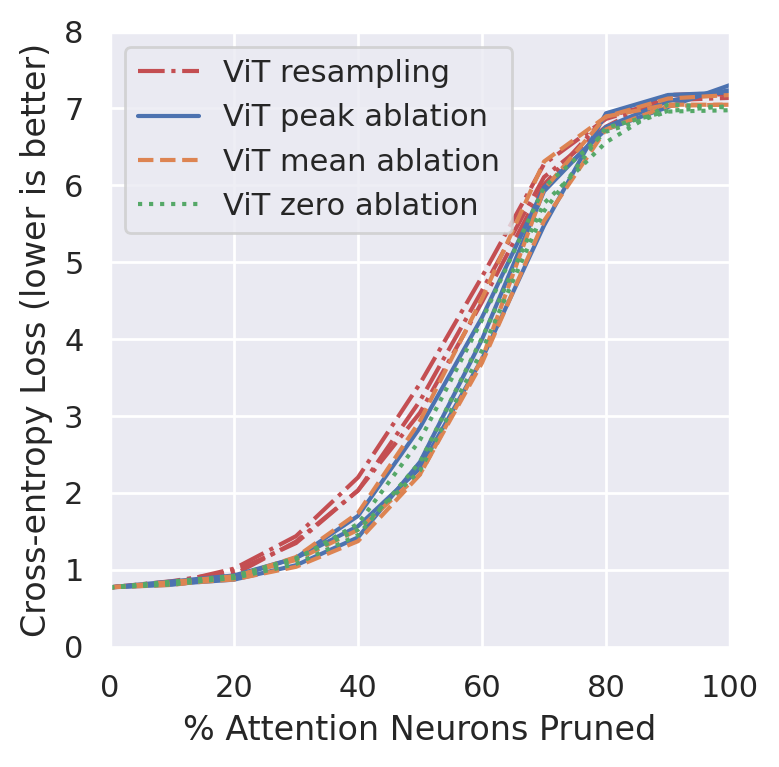

[(0.0, 80.31968031968032), (0.1, 78.52147852147853), (0.2, 75.22477522477523), (0.30000000000000004, 68.03196803196803), (0.4, 58.141858141858144), (0.5, 39.46053946053946), (0.6000000000000001, 21.278721278721278), (0.7000000000000001, 5.894105894105894), (0.8, 0.999000999000999), (0.9, 0.0), (1.0, 0.1998001998001998)]
[(0.0, 80.31968031968032), (0.1, 78.22177822177822), (0.2, 75.92407592407592), (0.30000000000000004, 67.93206793206794), (0.4, 54.345654345654346), (0.5, 36.96303696303696), (0.6000000000000001, 18.581418581418582), (0.7000000000000001, 5.294705294705294), (0.8, 0.7992007992007992), (0.9, 0.8991008991008991), (1.0, 0.0999000999000999)]
[(0.0, 80.31968031968032), (0.1, 78.12187812187813), (0.2, 74.32567432567433), (0.30000000000000004, 67.33266733266733), (0.4, 55.744255744255746), (0.5, 41.45854145854146), (0.6000000000000001, 20.77922077922078), (0.7000000000000001, 5.294705294705294), (0.8, 1.098901098901099), (0.9, 0.1998001998001998), (1.0, 0.1998001998001998)]
[(0.

In [29]:
peak_runs = [
    # "https://wandb.ai/seperability/nicky-peaks-test/runs/2ew9tibt"
    "https://wandb.ai/seperability/skylar-tests/runs/xboyc2n5",
    "https://wandb.ai/seperability/skylar-tests/runs/cfsm4ovh",
    "https://wandb.ai/seperability/skylar-tests/runs/dntbyhlv",
]

zero_runs = [
    # "https://wandb.ai/seperability/nicky-peaks-test/runs/hxd3k4b0",
    "https://wandb.ai/seperability/skylar-tests/runs/s61s2b3m",
    "https://wandb.ai/seperability/skylar-tests/runs/h9okljus",
    "https://wandb.ai/seperability/skylar-tests/runs/ozk64nau",
]

mean_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/bunfnz1s",
    "https://wandb.ai/seperability/skylar-tests/runs/u7bfg9h7",
    "https://wandb.ai/seperability/skylar-tests/runs/7dm60i7h"
]

resampling_runs = [
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/r3owylrg",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/9bfkdzrp",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/snp9go7b"
]

plt.figure(figsize=(4,4))
metric = "loss"
for i, x in enumerate(resampling_runs):
    label = "ViT resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
for i, x in enumerate(peak_runs):
    label = "ViT peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "ViT mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "ViT zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
plt.ylim(None, 8)
plt.ylabel("Cross-entropy Loss (lower is better)")
plt.title("")
plt.show()

plt.figure(figsize=(4,4))
metric = "base"
for i, x in enumerate(resampling_runs):
    label = "resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
for i, x in enumerate(peak_runs):
    label = "peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
plt.ylim(None, None)
plt.ylabel("Top1 Accuracy (%)")
plt.title("")
plt.show()

In [ ]:
datas_vit_loss = [
[(0.0, 0.7726), (0.1, 0.8325), (0.2, 0.9383), (0.30000000000000004, 1.3675), (0.4, 2.0324), (0.5, 3.1984), (0.6000000000000001, 4.6316), (0.7000000000000001, 6.1069), (0.8, 6.7625), (0.9, 7.1742), (1.0, 7.1994)],
[(0.0, 0.7726), (0.1, 0.8259), (0.2, 1.0155), (0.30000000000000004, 1.438), (0.4, 2.2019), (0.5, 3.4227), (0.6000000000000001, 4.8123), (0.7000000000000001, 6.2757), (0.8, 6.864), (0.9, 7.1072), (1.0, 7.137)],
[(0.0, 0.7726), (0.1, 0.8525), (0.2, 0.9768), (0.30000000000000004, 1.3484), (0.4, 2.033), (0.5, 3.0435), (0.6000000000000001, 4.4826), (0.7000000000000001, 6.0087), (0.8, 6.8931), (0.9, 7.0993), (1.0, 7.2007)],
[(0.0, 0.7726), (0.1, 0.8494), (0.2, 0.9268), (0.30000000000000004, 1.1543), (0.4, 1.5671), (0.5, 2.3206), (0.6000000000000001, 3.7426), (0.7000000000000001, 5.4769), (0.8, 6.9369), (0.9, 7.1743), (1.0, 7.2076)],
[(0.0, 0.7726), (0.1, 0.8066), (0.2, 0.9032), (0.30000000000000004, 1.1568), (0.4, 1.7014), (0.5, 2.8509), (0.6000000000000001, 4.2827), (0.7000000000000001, 5.9719), (0.8, 6.7268), (0.9, 7.0178), (1.0, 7.3039)],
[(0.0, 0.7726), (0.1, 0.8159), (0.2, 0.8723), (0.30000000000000004, 1.0598), (0.4, 1.4219), (0.5, 2.4034), (0.6000000000000001, 3.9968), (0.7000000000000001, 5.9219), (0.8, 6.7588), (0.9, 7.0944), (1.0, 7.2375)],
[(0.0, 0.7726), (0.1, 0.8153), (0.2, 0.8742), (0.30000000000000004, 1.0394), (0.4, 1.3728), (0.5, 2.2391), (0.6000000000000001, 3.7434), (0.7000000000000001, 5.9464), (0.8, 6.8942), (0.9, 7.0489), (1.0, 7.0473)],
[(0.0, 0.7726), (0.1, 0.8424), (0.2, 0.9165), (0.30000000000000004, 1.128), (0.4, 1.5198), (0.5, 2.2442), (0.6000000000000001, 3.6914), (0.7000000000000001, 5.5378), (0.8, 6.7275), (0.9, 7.0323), (1.0, 7.0497)],
[(0.0, 0.7726), (0.1, 0.8032), (0.2, 0.9047), (0.30000000000000004, 1.1658), (0.4, 1.7392), (0.5, 2.9375), (0.6000000000000001, 4.5286), (0.7000000000000001, 6.3094), (0.8, 6.8936), (0.9, 7.1282), (1.0, 7.1741)],
[(0.0, 0.7726), (0.1, 0.809), (0.2, 0.9012), (0.30000000000000004, 1.137), (0.4, 1.5983), (0.5, 2.6886), (0.6000000000000001, 4.2506), (0.7000000000000001, 5.9771), (0.8, 6.6968), (0.9, 6.959), (1.0, 6.9765)],
[(0.0, 0.7726), (0.1, 0.847), (0.2, 0.9203), (0.30000000000000004, 1.1517), (0.4, 1.5239), (0.5, 2.2905), (0.6000000000000001, 3.8525), (0.7000000000000001, 5.6638), (0.8, 6.7482), (0.9, 6.9668), (1.0, 7.0306)],
[(0.0, 0.7726), (0.1, 0.8219), (0.2, 0.8925), (0.30000000000000004, 1.0758), (0.4, 1.4515), (0.5, 2.4027), (0.6000000000000001, 4.0165), (0.7000000000000001, 5.7664), (0.8, 6.5594), (0.9, 7.0511), (1.0, 7.0094)],
]


datas_vit_top = [
[(0.0, 80.31968031968032), (0.1, 78.52147852147853), (0.2, 75.22477522477523), (0.30000000000000004, 68.03196803196803), (0.4, 58.141858141858144), (0.5, 39.46053946053946), (0.6000000000000001, 21.278721278721278), (0.7000000000000001, 5.894105894105894), (0.8, 0.999000999000999), (0.9, 0.0), (1.0, 0.1998001998001998)],
[(0.0, 80.31968031968032), (0.1, 78.22177822177822), (0.2, 75.92407592407592), (0.30000000000000004, 67.93206793206794), (0.4, 54.345654345654346), (0.5, 36.96303696303696), (0.6000000000000001, 18.581418581418582), (0.7000000000000001, 5.294705294705294), (0.8, 0.7992007992007992), (0.9, 0.8991008991008991), (1.0, 0.0999000999000999)],
[(0.0, 80.31968031968032), (0.1, 78.12187812187813), (0.2, 74.32567432567433), (0.30000000000000004, 67.33266733266733), (0.4, 55.744255744255746), (0.5, 41.45854145854146), (0.6000000000000001, 20.77922077922078), (0.7000000000000001, 5.294705294705294), (0.8, 1.098901098901099), (0.9, 0.1998001998001998), (1.0, 0.1998001998001998)],
[(0.0, 80.31968031968032), (0.1, 78.22177822177822), (0.2, 75.82417582417582), (0.30000000000000004, 71.12887112887113), (0.4, 62.93706293706294), (0.5, 50.24975024975025), (0.6000000000000001, 28.27172827172827), (0.7000000000000001, 7.992007992007992), (0.8, 0.7992007992007992), (0.9, 0.1998001998001998), (1.0, 0.0999000999000999)],
[(0.0, 80.31968031968032), (0.1, 78.42157842157842), (0.2, 77.82217782217782), (0.30000000000000004, 71.72827172827172), (0.4, 61.73826173826174), (0.5, 42.65734265734266), (0.6000000000000001, 22.977022977022976), (0.7000000000000001, 5.794205794205794), (0.8, 1.1988011988011988), (0.9, 0.1998001998001998), (1.0, 0.2997002997002997)],
[(0.0, 80.31968031968032), (0.1, 79.42057942057941), (0.2, 77.12287712287713), (0.30000000000000004, 72.92707292707293), (0.4, 67.93206793206794), (0.5, 50.24975024975025), (0.6000000000000001, 25.674325674325676), (0.7000000000000001, 6.593406593406593), (0.8, 1.2987012987012987), (0.9, 0.1998001998001998), (1.0, 0.0999000999000999)],
[(0.0, 80.31968031968032), (0.1, 79.62037962037962), (0.2, 76.82317682317682), (0.30000000000000004, 74.42557442557442), (0.4, 68.43156843156844), (0.5, 51.94805194805195), (0.6000000000000001, 30.46953046953047), (0.7000000000000001, 6.693306693306694), (0.8, 0.1998001998001998), (0.9, 0.0), (1.0, 0.0999000999000999)],
[(0.0, 80.31968031968032), (0.1, 78.12187812187813), (0.2, 75.62437562437563), (0.30000000000000004, 70.92907092907093), (0.4, 63.63636363636363), (0.5, 52.947052947052946), (0.6000000000000001, 27.57242757242757), (0.7000000000000001, 8.091908091908092), (0.8, 0.4995004995004995), (0.9, 0.0999000999000999), (1.0, 0.0999000999000999)],
[(0.0, 80.31968031968032), (0.1, 78.82117882117882), (0.2, 77.52247752247752), (0.30000000000000004, 71.22877122877122), (0.4, 60.63936063936064), (0.5, 41.05894105894106), (0.6000000000000001, 19.38061938061938), (0.7000000000000001, 4.395604395604396), (0.8, 0.8991008991008991), (0.9, 0.3996003996003996), (1.0, 0.4995004995004995)],
[(0.0, 80.31968031968032), (0.1, 77.72227772227772), (0.2, 77.62237762237763), (0.30000000000000004, 73.02697302697302), (0.4, 62.73726273726274), (0.5, 45.25474525474525), (0.6000000000000001, 23.476523476523475), (0.7000000000000001, 6.693306693306694), (0.8, 0.999000999000999), (0.9, 0.999000999000999), (1.0, 0.0999000999000999)],
[(0.0, 80.31968031968032), (0.1, 78.72127872127872), (0.2, 75.62437562437563), (0.30000000000000004, 70.62937062937063), (0.4, 63.93606393606394), (0.5, 51.34865134865135), (0.6000000000000001, 26.673326673326674), (0.7000000000000001, 6.593406593406593), (0.8, 1.2987012987012987), (0.9, 0.3996003996003996), (1.0, 0.1998001998001998)],
[(0.0, 80.31968031968032), (0.1, 79.22077922077922), (0.2, 76.12387612387613), (0.30000000000000004, 73.62637362637362), (0.4, 67.13286713286713), (0.5, 49.35064935064935), (0.6000000000000001, 25.874125874125873), (0.7000000000000001, 6.793206793206793), (0.8, 0.999000999000999), (0.9, 0.0999000999000999), (1.0, 0.1998001998001998)],
]


print("ViT")
latex_data(datas_vit_loss)
latex_data(datas_vit_top)

ViT
(2, 4)
0.77
3.22\pm0.16 & 2.52\pm0.23 & 2.47\pm0.33 & 2.46\pm0.17
7.13\pm0.03 & 7.10\pm0.06 & 7.07\pm0.04 & 6.99\pm0.04
(2, 4)
80.32
39.29\pm1.84 & 47.72\pm3.58 & 48.65\pm5.38 & 48.65\pm2.54
0.37\pm0.39 & 0.20\pm0.00 & 0.17\pm0.17 & 0.50\pm0.37


In [1]:
# ROBERTA

peak_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/hy3eax7d",
    "https://wandb.ai/seperability/nicky-roberta-semifinal/runs/qkmjnfkt",
    "https://wandb.ai/seperability/nicky-roberta-semifinal/runs/qkmjnfkt",
]

zero_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/kl65988t",
    "https://wandb.ai/seperability/nicky-peaks-test/runs/i0niy05a",
    "https://wandb.ai/seperability/nicky-peaks-test/runs/kvvhf9o8",
]

mean_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/k9illdfp",
    "https://wandb.ai/seperability/nicky-peaks-test/runs/pg5k66sw",
    "https://wandb.ai/seperability/nicky-peaks-test/runs/su9pkfjc",
]

resampling_runs = [
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/adh7wilv", # char
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/foexiy1o",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/q7esqitz",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/46xxl6b7", # ids
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/dbvqstxm",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/hvzr90t0",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/ex7yo3bg", # gen
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/u0ps38bi",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/nzkn17kc"
]

plt.figure(figsize=(4,4))
metric = "loss"
for i, x in enumerate(resampling_runs):
    label = "RoBERTa resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
for i, x in enumerate(peak_runs):
    label = "RoBERTa peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "RoBERTa mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "RoBERTa zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
plt.ylim(3, 16)
plt.ylabel("Cross-entropy Loss (lower is better)")
plt.title("")
plt.show()

plt.figure(figsize=(4,4))
metric = "base"
for i, x in enumerate(resampling_runs):
    label = "resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
for i, x in enumerate(peak_runs):
    label = "peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
plt.ylim(None, None)
plt.ylabel("Top1 Accuracy (%)")
plt.title("")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
rob_loss_datas = [
[(0.0, 3.7483), (0.05, 3.657), (0.1, 3.8074), (0.15000000000000002, 3.7224), (0.2, 4.1161), (0.25, 4.6527), (0.30000000000000004, 5.2381), (0.35000000000000003, 6.0871), (0.4, 6.6809), (0.45, 7.7106), (0.5, 8.4197), (0.55, 9.6519), (0.6000000000000001, 10.6553), (0.65, 11.2181), (0.7000000000000001, 11.8157), (0.75, 12.5119), (0.8, 13.3227), (0.8500000000000001, 13.8086), (0.9, 14.398), (0.9500000000000001, 14.8001), (1.0, 15.5805)],
[(0.0, 3.6354), (0.05, 3.6247), (0.1, 3.8335), (0.15000000000000002, 3.8497), (0.2, 4.0473), (0.25, 4.4346), (0.30000000000000004, 4.8431), (0.35000000000000003, 5.5122), (0.4, 6.6038), (0.45, 7.6291), (0.5, 8.6563), (0.55, 9.4186), (0.6000000000000001, 10.233), (0.65, 11.0542), (0.7000000000000001, 11.9737), (0.75, 12.4541), (0.8, 12.9894), (0.8500000000000001, 13.6803), (0.9, 14.2841), (0.9500000000000001, 14.8875), (1.0, 15.7164)],
[(0.0, 3.6613), (0.05, 3.7421), (0.1, 3.6646), (0.15000000000000002, 3.9663), (0.2, 4.2111), (0.25, 4.5152), (0.30000000000000004, 4.9672), (0.35000000000000003, 5.9291), (0.4, 6.6202), (0.45, 7.9949), (0.5, 8.9598), (0.55, 9.4474), (0.6000000000000001, 10.3595), (0.65, 11.0885), (0.7000000000000001, 11.6341), (0.75, 12.3592), (0.8, 12.9965), (0.8500000000000001, 13.9888), (0.9, 14.4332), (0.9500000000000001, 15.0141), (1.0, 15.4777)],
[(0.0, 3.7483), (0.05, 3.6226), (0.1, 3.74), (0.15000000000000002, 3.6374), (0.2, 3.9911), (0.25, 4.4615), (0.30000000000000004, 5.0201), (0.35000000000000003, 5.6697), (0.4, 6.2986), (0.45, 7.3531), (0.5, 8.1006), (0.55, 8.9374), (0.6000000000000001, 9.527), (0.65, 9.887), (0.7000000000000001, 10.1888), (0.75, 10.5677), (0.8, 10.6891), (0.8500000000000001, 10.8941), (0.9, 11.2303), (0.9500000000000001, 11.3961), (1.0, 11.6872)],
[(0.0, 3.6354), (0.05, 3.598), (0.1, 3.8493), (0.15000000000000002, 3.862), (0.2, 3.9784), (0.25, 4.3252), (0.30000000000000004, 4.6809), (0.35000000000000003, 5.2228), (0.4, 5.7993), (0.45, 6.7296), (0.5, 7.6803), (0.55, 8.5814), (0.6000000000000001, 9.2813), (0.65, 9.7978), (0.7000000000000001, 10.3689), (0.75, 10.5794), (0.8, 10.7049), (0.8500000000000001, 11.1918), (0.9, 11.4437), (0.9500000000000001, 11.1284), (1.0, 11.7335)],
[(0.0, 3.6614), (0.05, 3.731), (0.1, 3.6367), (0.15000000000000002, 3.8952), (0.2, 4.0491), (0.25, 4.2165), (0.30000000000000004, 4.4498), (0.35000000000000003, 5.0888), (0.4, 5.651), (0.45, 6.8098), (0.5, 7.7772), (0.55, 8.4462), (0.6000000000000001, 9.3278), (0.65, 9.9492), (0.7000000000000001, 10.255), (0.75, 10.4679), (0.8, 10.643), (0.8500000000000001, 10.9949), (0.9, 11.2966), (0.9500000000000001, 11.3763), (1.0, 11.5506)],
[(0.0, 3.7483), (0.05, 3.6676), (0.1, 3.8229), (0.15000000000000002, 3.6607), (0.2, 3.9476), (0.25, 4.4251), (0.30000000000000004, 5.5265), (0.35000000000000003, 6.4444), (0.4, 7.2623), (0.45, 8.7986), (0.5, 10.2725), (0.55, 11.4792), (0.6000000000000001, 12.8965), (0.65, 14.2471), (0.7000000000000001, 15.5527), (0.75, 16.2851), (0.8, 17.4079), (0.8500000000000001, 19.0347), (0.9, 21.1141), (0.9500000000000001, 22.6208), (1.0, 24.0288)],
[(0.0, 3.6354), (0.05, 3.6314), (0.1, 4.0741), (0.15000000000000002, 4.256), (0.2, 4.5315), (0.25, 4.9162), (0.30000000000000004, 5.4428), (0.35000000000000003, 6.1341), (0.4, 7.1029), (0.45, 8.3787), (0.5, 9.8091), (0.55, 11.1407), (0.6000000000000001, 12.531), (0.65, 13.5365), (0.7000000000000001, 14.819), (0.75, 15.8834), (0.8, 16.9805), (0.8500000000000001, 18.4491), (0.9, 20.7761), (0.9500000000000001, 22.0974), (1.0, 23.9211)],
[(0.0, 3.5172), (0.05, 3.6748), (0.1, 3.7932), (0.15000000000000002, 4.1705), (0.2, 4.7749), (0.25, 5.1212), (0.30000000000000004, 5.7159), (0.35000000000000003, 6.5242), (0.4, 8.01), (0.45, 9.1541), (0.5, 10.1952), (0.55, 11.0697), (0.6000000000000001, 12.5784), (0.65, 13.6136), (0.7000000000000001, 14.9687), (0.75, 16.0155), (0.8, 17.2652), (0.8500000000000001, 18.8071), (0.9, 20.6593), (0.9500000000000001, 22.2486), (1.0, 23.9638)],
[(0.0, 3.5839), (0.05, 3.8104), (0.1, 3.8423), (0.15000000000000002, 3.8359), (0.2, 3.7212), (0.25, 3.7802), (0.30000000000000004, 3.9749), (0.35000000000000003, 4.1232), (0.4, 4.3358), (0.45, 4.7874), (0.5, 5.1376), (0.55, 5.5246), (0.6000000000000001, 6.1442), (0.65, 6.9294), (0.7000000000000001, 8.0966), (0.75, 10.7858), (0.8, 12.3811), (0.8500000000000001, 13.1607), (0.9, 14.6756), (0.9500000000000001, 14.4417), (1.0, 15.2707)],
[(0.0, 3.8729), (0.05, 3.6438), (0.1, 3.7824), (0.15000000000000002, 3.7785), (0.2, 3.6097), (0.25, 3.7208), (0.30000000000000004, 4.1149), (0.35000000000000003, 4.0753), (0.4, 4.2277), (0.45, 4.3826), (0.5, 4.9369), (0.55, 5.522), (0.6000000000000001, 6.3598), (0.65, 7.1331), (0.7000000000000001, 8.4857), (0.75, 9.6635), (0.8, 11.8328), (0.8500000000000001, 12.2683), (0.9, 12.9514), (0.9500000000000001, 13.2764), (1.0, 14.1549)],
[(0.0, 3.8729), (0.05, 3.6438), (0.1, 3.7824), (0.15000000000000002, 3.7785), (0.2, 3.6097), (0.25, 3.7208), (0.30000000000000004, 4.1149), (0.35000000000000003, 4.0753), (0.4, 4.2277), (0.45, 4.3826), (0.5, 4.9369), (0.55, 5.522), (0.6000000000000001, 6.3598), (0.65, 7.1331), (0.7000000000000001, 8.4857), (0.75, 9.6635), (0.8, 11.8328), (0.8500000000000001, 12.2683), (0.9, 12.9514), (0.9500000000000001, 13.2764), (1.0, 14.1549)],
[(0.0, 3.5839), (0.05, 3.8139), (0.1, 3.8556), (0.15000000000000002, 3.8497), (0.2, 3.7369), (0.25, 3.7943), (0.30000000000000004, 4.0016), (0.35000000000000003, 4.1639), (0.4, 4.3864), (0.45, 4.8451), (0.5, 5.2287), (0.55, 5.734), (0.6000000000000001, 6.3111), (0.65, 7.0027), (0.7000000000000001, 7.9155), (0.75, 9.2912), (0.8, 10.4766), (0.8500000000000001, 11.2534), (0.9, 13.8306), (0.9500000000000001, 14.895), (1.0, 16.0541)],
[(0.0, 3.7313), (0.05, 3.8092), (0.1, 3.7914), (0.15000000000000002, 3.5603), (0.2, 3.9261), (0.25, 3.8658), (0.30000000000000004, 4.0224), (0.35000000000000003, 4.266), (0.4, 4.4006), (0.45, 4.6968), (0.5, 5.1629), (0.55, 5.6516), (0.6000000000000001, 6.2952), (0.65, 7.069), (0.7000000000000001, 8.081), (0.75, 9.2406), (0.8, 10.6594), (0.8500000000000001, 12.3033), (0.9, 13.6228), (0.9500000000000001, 14.7378), (1.0, 15.9786)],
[(0.0, 3.751), (0.05, 3.5407), (0.1, 3.661), (0.15000000000000002, 3.8335), (0.2, 3.708), (0.25, 3.9088), (0.30000000000000004, 4.0384), (0.35000000000000003, 4.2067), (0.4, 4.361), (0.45, 4.8095), (0.5, 5.1647), (0.55, 5.8654), (0.6000000000000001, 6.3598), (0.65, 7.1628), (0.7000000000000001, 8.4153), (0.75, 9.1834), (0.8, 10.6352), (0.8500000000000001, 11.8383), (0.9, 12.4697), (0.9500000000000001, 13.7132), (1.0, 15.5813)],
[(0.0, 3.5839), (0.05, 3.8017), (0.1, 3.8365), (0.15000000000000002, 3.8388), (0.2, 3.7223), (0.25, 3.7867), (0.30000000000000004, 4.02), (0.35000000000000003, 4.4607), (0.4, 4.6652), (0.45, 5.2084), (0.5, 5.6376), (0.55, 6.2947), (0.6000000000000001, 6.6739), (0.65, 7.2461), (0.7000000000000001, 7.952), (0.75, 9.3885), (0.8, 10.7988), (0.8500000000000001, 11.8584), (0.9, 13.5569), (0.9500000000000001, 13.6804), (1.0, 13.877)],
[(0.0, 3.7313), (0.05, 3.8199), (0.1, 3.789), (0.15000000000000002, 3.5553), (0.2, 3.904), (0.25, 3.8077), (0.30000000000000004, 3.9912), (0.35000000000000003, 4.2372), (0.4, 4.4025), (0.45, 4.8911), (0.5, 5.4732), (0.55, 5.8756), (0.6000000000000001, 6.3979), (0.65, 7.2684), (0.7000000000000001, 8.1341), (0.75, 9.0915), (0.8, 10.6661), (0.8500000000000001, 12.2407), (0.9, 13.1501), (0.9500000000000001, 14.8404), (1.0, 13.7669)],
[(0.0, 3.751), (0.05, 3.5446), (0.1, 3.6769), (0.15000000000000002, 3.8676), (0.2, 3.7328), (0.25, 3.9084), (0.30000000000000004, 3.9959), (0.35000000000000003, 4.1636), (0.4, 4.2227), (0.45, 4.5716), (0.5, 4.8734), (0.55, 5.492), (0.6000000000000001, 6.0632), (0.65, 6.691), (0.7000000000000001, 7.8029), (0.75, 8.6289), (0.8, 10.2432), (0.8500000000000001, 11.7608), (0.9, 12.2559), (0.9500000000000001, 13.0328), (1.0, 14.1243)],
]

rob_top_datas = [
[(0.0, 73.0426403276319), (0.05, 72.3441615452151), (0.1, 70.40070665703044), (0.15000000000000002, 68.92491329945963), (0.2, 64.98835621938488), (0.25, 59.398196184851145), (0.30000000000000004, 51.98339851544417), (0.35000000000000003, 42.52790492250863), (0.4, 34.30498675018068), (0.45, 26.178430900184694), (0.5, 19.614485039116058), (0.55, 12.398618806713241), (0.6000000000000001, 8.072874493927126), (0.65, 6.5208715779391815), (0.7000000000000001, 5.105250423421244), (0.75, 4.509537872136643), (0.8, 3.58899911283168), (0.8500000000000001, 3.1925931838135524), (0.9, 2.7864771540994138), (0.9500000000000001, 2.5727881280748446), (1.0, 2.376937284188549)],
[(0.0, 73.03461013410423), (0.05, 72.15128884606119), (0.1, 70.43282743114109), (0.15000000000000002, 68.92010535557506), (0.2, 66.64257608608368), (0.25, 61.969003452983216), (0.30000000000000004, 55.75065847234416), (0.35000000000000003, 47.16509395919026), (0.4, 34.59956448100653), (0.45, 25.7482640274563), (0.5, 18.743447052181626), (0.55, 13.331720300024195), (0.6000000000000001, 9.524961690458907), (0.65, 6.9300570143740465), (0.7000000000000001, 5.0363157474658795), (0.75, 4.6396761133603235), (0.8, 4.585240504296154), (0.8500000000000001, 3.8874102750221793), (0.9, 3.1971439904799683), (0.9500000000000001, 2.9068825910931175), (1.0, 2.344816510077893)],
[(0.0, 72.4493910799258), (0.05, 71.57028792644569), (0.1, 71.15089926606984), (0.15000000000000002, 67.47771621296073), (0.2, 65.12486950935518), (0.25, 60.77250461736128), (0.30000000000000004, 53.07692307692308), (0.35000000000000003, 42.222044855934236), (0.4, 33.878542510121456), (0.45, 23.58254697959513), (0.5, 17.35174395402666), (0.55, 13.145426804785995), (0.6000000000000001, 9.965470167831045), (0.65, 7.097346560206469), (0.7000000000000001, 6.16968632771969), (0.75, 5.139323857704971), (0.8, 4.488878181964186), (0.8500000000000001, 3.934794828555368), (0.9, 3.5894965068658156), (0.9500000000000001, 2.963141411708022), (1.0, 2.3367863165502287)],
[(0.0, 73.0426403276319), (0.05, 72.48782823848671), (0.1, 70.72191439813699), (0.15000000000000002, 69.37656262601823), (0.2, 66.14470408736851), (0.25, 61.16210391890813), (0.30000000000000004, 55.11213983558145), (0.35000000000000003, 47.16132658797077), (0.4, 38.4726571910383), (0.45, 29.414598891833293), (0.5, 22.292120332284863), (0.55, 16.767044085762468), (0.6000000000000001, 13.846153846153847), (0.65, 12.139835581451033), (0.7000000000000001, 9.79917735301234), (0.75, 8.707797908851465), (0.8, 8.282926042422776), (0.8500000000000001, 8.157075584643627), (0.9, 7.548381916004176), (0.9500000000000001, 7.347366723122833), (1.0, 6.9862683690676946)],
[(0.0, 73.03461013410423), (0.05, 72.31992291014214), (0.1, 70.50509917289007), (0.15000000000000002, 69.3989943331471), (0.2, 67.08423673010519), (0.25, 63.51080061029471), (0.30000000000000004, 57.251177268736534), (0.35000000000000003, 51.31058956367449), (0.4, 43.35833534962497), (0.45, 34.11285816904781), (0.5, 26.623114767319944), (0.55, 20.017743366400516), (0.6000000000000001, 15.21090410516977), (0.65, 12.679675580181483), (0.7000000000000001, 10.399872296272648), (0.75, 9.40080971659919), (0.8, 8.600337268128161), (0.8500000000000001, 8.040971046052102), (0.9, 7.473224910749702), (0.9500000000000001, 7.40080971659919), (1.0, 7.235204368425279)],
[(0.0, 72.4493910799258), (0.05, 71.58641825953706), (0.1, 71.7880474231793), (0.15000000000000002, 68.52164137155705), (0.2, 67.10029711716052), (0.25, 64.48245402714205), (0.30000000000000004, 59.27125506072875), (0.35000000000000003, 52.11908372575625), (0.4, 43.29554655870445), (0.45, 33.49463666424712), (0.5, 25.56468991938702), (0.55, 18.967317112342407), (0.6000000000000001, 14.357986027463262), (0.65, 11.000887168320025), (0.7000000000000001, 10.272168568920105), (0.75, 9.082148879788003), (0.8, 8.624427848711154), (0.8500000000000001, 8.463823978157874), (0.9, 7.628683851280816), (0.9500000000000001, 7.71701598008512), (1.0, 6.93808720790171)],
[(0.0, 73.0426403276319), (0.05, 72.53571713624392), (0.1, 70.75403517224765), (0.15000000000000002, 70.27179611258973), (0.2, 67.64635027704168), (0.25, 62.94197461888419), (0.30000000000000004, 53.71538031766302), (0.35000000000000003, 44.11788324098611), (0.4, 34.31301694370834), (0.45, 23.303621617280978), (0.5, 15.80772642955077), (0.55, 10.029711716052358), (0.6000000000000001, 7.068825910931174), (0.65, 5.339612099928167), (0.7000000000000001, 4.36325510121784), (0.75, 3.6714821613855855), (0.8, 3.153480119364465), (0.8500000000000001, 2.953148695027536), (0.9, 2.1039107042479723), (0.9500000000000001, 1.8388579724171303), (1.0, 1.5658877378944833)],
[(0.0, 73.03461013410423), (0.05, 71.93447362081426), (0.1, 68.56179233919538), (0.15000000000000002, 66.66932716098651), (0.2, 64.98032602585722), (0.25, 61.302497390187106), (0.30000000000000004, 53.515843243674674), (0.35000000000000003, 45.7214291475119), (0.4, 35.34155980320994), (0.45, 25.652486231941896), (0.5, 17.582063069602388), (0.55, 11.525122993789822), (0.6000000000000001, 7.95225421404952), (0.65, 5.605075082309484), (0.7000000000000001, 3.9987229627264744), (0.75, 3.408906882591093), (0.8, 3.332530313980567), (0.8500000000000001, 2.9921767884506814), (0.9, 2.157873859579532), (0.9500000000000001, 1.94331983805668), (1.0, 1.8148237372520677)],
[(0.0, 73.81353890628765), (0.05, 71.73159125735947), (0.1, 70.30405677877248), (0.15000000000000002, 67.29574965723042), (0.2, 62.81217377338794), (0.25, 58.53697878861198), (0.30000000000000004, 51.92323134987553), (0.35000000000000003, 40.536416927647956), (0.4, 28.16991889504537), (0.45, 20.316389624989963), (0.5, 14.896008993816752), (0.55, 11.916807195053401), (0.6000000000000001, 7.941293137643792), (0.65, 6.1993094033566205), (0.7000000000000001, 4.777327935222672), (0.75, 4.561149923713161), (0.8, 3.822888942656666), (0.8500000000000001, 3.1237452822613023), (0.9, 2.513450574158837), (0.9500000000000001, 1.8357410806927927), (1.0, 1.5177065767284992)],
[(0.0, 72.79370432827432), (0.05, 72.95075425013968), (0.1, 71.50610583446404), (0.15000000000000002, 71.38638359007103), (0.2, 70.77812575283065), (0.25, 69.38087207901711), (0.30000000000000004, 67.4570529881442), (0.35000000000000003, 64.54552786515042), (0.4, 62.964747450413554), (0.45, 57.375594806032744), (0.5, 50.75303643724696), (0.55, 45.858536978788614), (0.6000000000000001, 38.23695459311235), (0.65, 30.69139966273187), (0.7000000000000001, 23.639003145414954), (0.75, 14.278873014606114), (0.8, 9.99274135010888), (0.8500000000000001, 7.789927368505068), (0.9, 5.489878542510121), (0.9500000000000001, 5.24383430441376), (1.0, 3.734172110654085)],
[(0.0, 72.03886613667389), (0.05, 73.04653204565409), (0.1, 71.43427248782824), (0.15000000000000002, 72.23242078378162), (0.2, 70.41696911041213), (0.25, 69.5187165775401), (0.30000000000000004, 67.09412049358819), (0.35000000000000003, 65.20073429643227), (0.4, 61.97703364651088), (0.45, 58.9724977820792), (0.5, 53.45592386482781), (0.55, 44.527423110896976), (0.6000000000000001, 36.78665496049166), (0.65, 27.598999919348334), (0.7000000000000001, 19.808049036212598), (0.75, 14.736842105263158), (0.8, 10.950594620480485), (0.8500000000000001, 7.893686646979009), (0.9, 6.807000564561658), (0.9500000000000001, 6.512486950935518), (1.0, 4.365871178865033)],
[(0.0, 72.03886613667389), (0.05, 73.04653204565409), (0.1, 71.43427248782824), (0.15000000000000002, 72.23242078378162), (0.2, 70.41696911041213), (0.25, 69.5187165775401), (0.30000000000000004, 67.09412049358819), (0.35000000000000003, 65.20073429643227), (0.4, 61.97703364651088), (0.45, 58.9724977820792), (0.5, 53.45592386482781), (0.55, 44.527423110896976), (0.6000000000000001, 36.78665496049166), (0.65, 27.598999919348334), (0.7000000000000001, 19.808049036212598), (0.75, 14.736842105263158), (0.8, 10.950594620480485), (0.8500000000000001, 7.893686646979009), (0.9, 6.807000564561658), (0.9500000000000001, 6.512486950935518), (1.0, 4.365871178865033)],
[(0.0, 72.79370432827432), (0.05, 72.8150690398276), (0.1, 71.54601324926172), (0.15000000000000002, 71.45821693670683), (0.2, 70.83433710752429), (0.25, 69.37284188548944), (0.30000000000000004, 67.43285748850714), (0.35000000000000003, 64.36809420114525), (0.4, 62.627479322251666), (0.45, 56.673925316557785), (0.5, 49.473684210526315), (0.55, 43.277683684168075), (0.6000000000000001, 37.107831276715864), (0.65, 30.68336946920421), (0.7000000000000001, 24.380998467618355), (0.75, 18.373373772846996), (0.8, 15.364142269537865), (0.8500000000000001, 13.241280229866708), (0.9, 10.412955465587045), (0.9500000000000001, 9.657594381035997), (1.0, 7.944189047503831)],
[(0.0, 72.20743608355512), (0.05, 72.48052678069541), (0.1, 72.03000241954996), (0.15000000000000002, 71.47368421052632), (0.2, 70.51640194748184), (0.25, 69.27978062746996), (0.30000000000000004, 67.43319838056681), (0.35000000000000003, 65.24064171122994), (0.4, 61.00491975159287), (0.45, 58.1787521079258), (0.5, 52.91897534730587), (0.55, 44.95302336786317), (0.6000000000000001, 38.366988586479366), (0.65, 29.945963384143884), (0.7000000000000001, 22.66923632859552), (0.75, 18.178885393983386), (0.8, 14.718928945882732), (0.8500000000000001, 11.307363497056214), (0.9, 10.222436360716292), (0.9500000000000001, 9.250782943868947), (1.0, 7.887732881684006)],
[(0.0, 73.03461013410423), (0.05, 72.22672064777328), (0.1, 71.85417168553762), (0.15000000000000002, 71.02706175218823), (0.2, 69.79595128639406), (0.25, 69.51738536898739), (0.30000000000000004, 67.01196498835623), (0.35000000000000003, 64.89199389705291), (0.4, 60.016194331983804), (0.45, 55.60125816598113), (0.5, 50.91945715891753), (0.55, 43.483119163540586), (0.6000000000000001, 36.16799164859873), (0.65, 29.856259535854814), (0.7000000000000001, 22.523744911804613), (0.75, 18.895045370593433), (0.8, 15.530394282502208), (0.8500000000000001, 13.549479796757803), (0.9, 10.75893217194935), (0.9500000000000001, 9.31502449209026), (1.0, 7.981482959533881)],
[(0.0, 72.79370432827432), (0.05, 72.20847633490303), (0.1, 70.82767978290366), (0.15000000000000002, 70.62814270891532), (0.2, 69.99919698064723), (0.25, 68.52967156508471), (0.30000000000000004, 65.79562867973223), (0.35000000000000003, 59.83547060246794), (0.4, 57.905725527985226), (0.45, 51.173481732397775), (0.5, 44.17004048582996), (0.55, 37.17235260908138), (0.6000000000000001, 33.793047826437615), (0.65, 28.997028828394765), (0.7000000000000001, 24.52617146544076), (0.75, 19.315188762071994), (0.8, 14.388257117509477), (0.8500000000000001, 12.626706041982601), (0.9, 10.809716599190283), (0.9500000000000001, 10.902705722723281), (1.0, 10.37986934430196)],
[(0.0, 72.20743608355512), (0.05, 72.57688910302738), (0.1, 71.88482942172756), (0.15000000000000002, 71.32793522267207), (0.2, 70.08540186766702), (0.25, 69.03782563109928), (0.30000000000000004, 65.61133603238866), (0.35000000000000003, 63.38893766461808), (0.4, 59.55318977336882), (0.45, 54.12350437645547), (0.5, 48.55055006825665), (0.55, 42.96956556653015), (0.6000000000000001, 37.60874770532365), (0.65, 29.978224050326638), (0.7000000000000001, 23.263470649642656), (0.75, 19.69513670457295), (0.8, 15.081861440438745), (0.8500000000000001, 12.03322848616824), (0.9, 10.736368746486791), (0.9500000000000001, 10.013651328997028), (1.0, 10.412130010484717)],
[(0.0, 73.03461013410423), (0.05, 71.82995951417004), (0.1, 71.07524291335422), (0.15000000000000002, 70.2963141411708), (0.2, 69.40882329220098), (0.25, 69.03557375732755), (0.30000000000000004, 66.68272705372199), (0.35000000000000003, 64.57881634947402), (0.4, 60.99595141700405), (0.45, 57.464311638035326), (0.5, 53.36063599132739), (0.55, 47.346156915954985), (0.6000000000000001, 38.90628764153216), (0.65, 33.7428732032442), (0.7000000000000001, 26.203208556149733), (0.75, 20.93471452662009), (0.8, 16.606440215209187), (0.8500000000000001, 14.122106621501734), (0.9, 12.041293652713929), (0.9500000000000001, 10.53561390829519), (1.0, 9.857131455024344)],
]

print("RoBERTa")
latex_data(rob_loss_datas, 10, -3)
latex_data(rob_top_datas, 10, -3)


(2, 6)
3.75
8.68\pm0.22 & 7.85\pm0.18 & 10.09\pm0.20 & 5.00\pm0.09 & 5.19\pm0.03 & 5.33\pm0.33
14.37\pm0.06 & 11.32\pm0.09 & 20.85\pm0.19 & 13.53\pm0.81 & 13.31\pm0.60 & 12.99\pm0.54
(2, 6)
73.04
18.57\pm0.93 & 24.83\pm1.84 & 16.10\pm1.12 & 52.55\pm1.27 & 51.10\pm1.41 & 48.69\pm3.75
3.19\pm0.33 & 7.55\pm0.06 & 2.26\pm0.18 & 6.37\pm0.62 & 10.46\pm0.22 & 11.20\pm0.60


[(0.0, 1.7114), (0.1, 1.7819), (0.2, 1.9155), (0.30000000000000004, 2.2671), (0.4, 2.9647), (0.5, 4.5267), (0.6000000000000001, 6.3413), (0.7000000000000001, 9.1925), (0.8, 11.2961), (0.9, 12.9377), (1.0, 13.1847)]
[(0.0, 1.7114), (0.1, 1.7916), (0.2, 1.9641), (0.30000000000000004, 2.3274), (0.4, 3.2542), (0.5, 4.7146), (0.6000000000000001, 6.2757), (0.7000000000000001, 8.5715), (0.8, 11.1841), (0.9, 12.5087), (1.0, 13.1727)]
[(0.0, 1.7114), (0.1, 1.7699), (0.2, 1.9148), (0.30000000000000004, 2.2841), (0.4, 2.9603), (0.5, 4.3276), (0.6000000000000001, 6.5085), (0.7000000000000001, 8.9789), (0.8, 11.1393), (0.9, 12.6986), (1.0, 13.178)]
[(0.0, 1.7114), (0.1, 1.7684), (0.2, 1.9293), (0.30000000000000004, 2.325), (0.4, 3.2075), (0.5, 4.6706), (0.6000000000000001, 5.7818), (0.7000000000000001, 6.4776), (0.8, 6.9396), (0.9, 7.2029), (1.0, 7.4618)]
[(0.0, 1.7114), (0.1, 1.7694), (0.2, 1.9263), (0.30000000000000004, 2.3489), (0.4, 3.5278), (0.5, 4.9122), (0.6000000000000001, 5.8853), (0.70000

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


[(0.0, 1.6693), (0.1, 1.672), (0.2, 1.7028), (0.30000000000000004, 1.7633), (0.4, 1.9466), (0.5, 2.3555), (0.6000000000000001, 3.4454), (0.7000000000000001, 4.5661), (0.8, 5.8157), (0.9, 7.0388), (1.0, 7.6296)]
[(0.0, 1.6693), (0.1, 1.6862), (0.2, 1.7197), (0.30000000000000004, 1.7905), (0.4, 1.9636), (0.5, 2.4423), (0.6000000000000001, 3.5494), (0.7000000000000001, 4.9028), (0.8, 6.1469), (0.9, 6.7017), (1.0, 7.4625)]
[(0.0, 1.6693), (0.1, 1.6771), (0.2, 1.7131), (0.30000000000000004, 1.7672), (0.4, 1.9502), (0.5, 2.4703), (0.6000000000000001, 3.7224), (0.7000000000000001, 4.7939), (0.8, 6.2123), (0.9, 6.8016), (1.0, 7.3881)]
[(0.0, 1.6693), (0.1, 1.678), (0.2, 1.7), (0.30000000000000004, 1.7728), (0.4, 2.0179), (0.5, 2.5719), (0.6000000000000001, 3.4439), (0.7000000000000001, 4.721), (0.8, 5.859), (0.9, 6.7416), (1.0, 7.4977)]


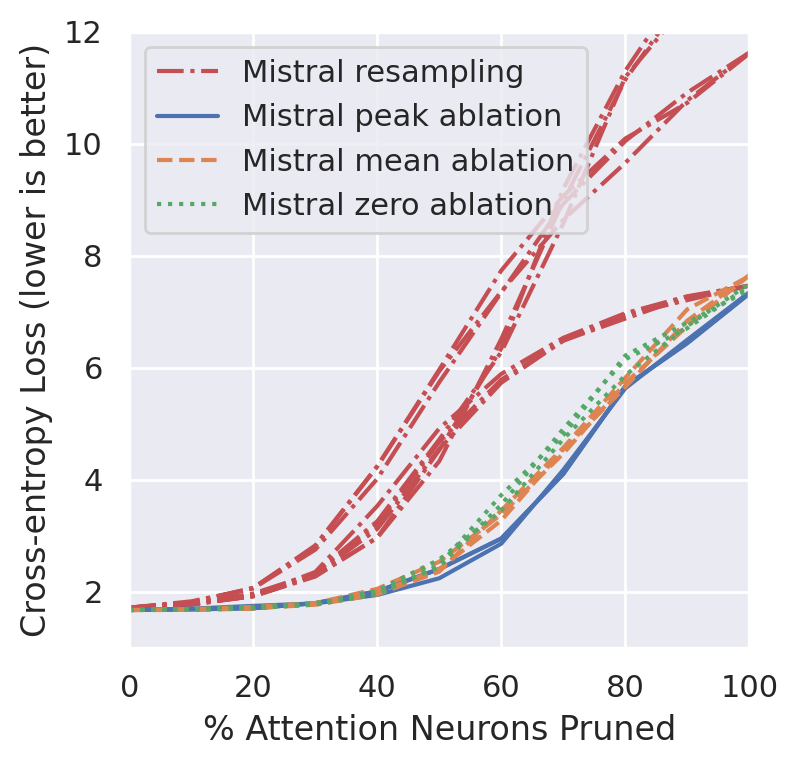

[(0.0, 62.38256322382416), (0.1, 60.84849917277239), (0.2, 58.2848321909714), (0.30000000000000004, 53.00387024344127), (0.4, 43.28246868352635), (0.5, 26.895976128574805), (0.6000000000000001, 13.661073032380052), (0.7000000000000001, 4.884335854407942), (0.8, 2.504579295674781), (0.9, 1.1256204207043252), (1.0, 0.7156995982037343)]
[(0.0, 62.38256322382416), (0.1, 60.86400969038053), (0.2, 57.877127156700546), (0.30000000000000004, 52.212095249350035), (0.4, 40.22689671472465), (0.5, 25.700189080595603), (0.6000000000000001, 14.977251240841408), (0.7000000000000001, 5.569014417395414), (0.8, 1.7201902623493264), (0.9, 1.0968151737177971), (1.0, 0.7230855589695108)]
[(0.0, 62.38256322382416), (0.1, 60.95781139210589), (0.2, 58.518967147246514), (0.30000000000000004, 52.79484755376979), (0.4, 43.24553887969747), (0.5, 28.42856298747341), (0.6000000000000001, 13.860493973056014), (0.7000000000000001, 5.461179390215079), (0.8, 2.012674308674072), (0.9, 0.8634188135192626), (1.0, 0.711268

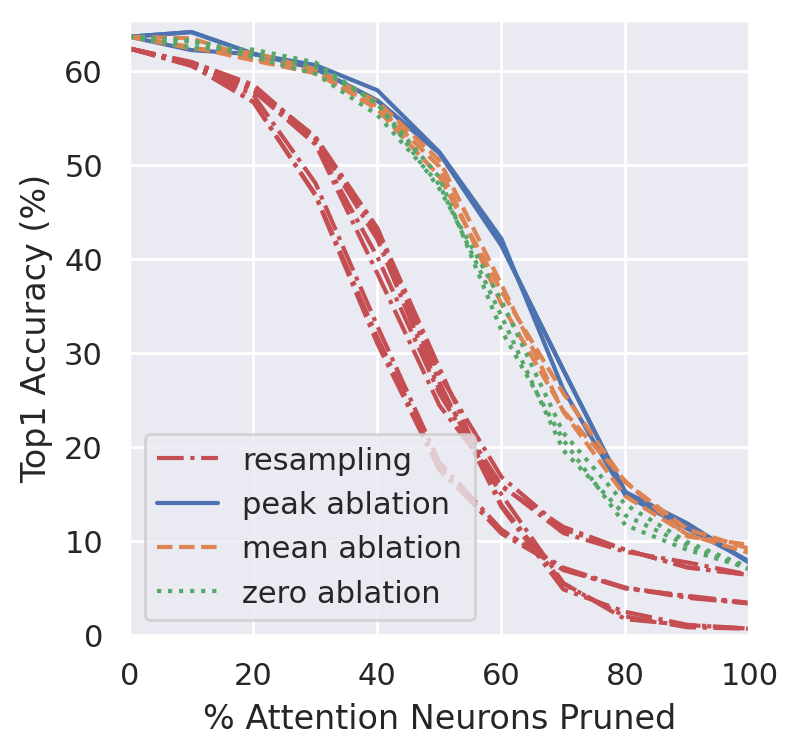

In [4]:
bayes_runs = [
"https://wandb.ai/seperability/skylar-tests/runs/tk7xeepi", # bayes
"https://wandb.ai/seperability/skylar-tests/runs/g5yxirxd",
"https://wandb.ai/seperability/skylar-tests/runs/ab2h43rs",
]

peak_runs = [
"https://wandb.ai/seperability/skylar-tests/runs/n5d1vgix", # peak
"https://wandb.ai/seperability/skylar-tests/runs/7vzdrk7z",
"https://wandb.ai/seperability/skylar-tests/runs/giqdglvg",
]

mean_runs = [
"https://wandb.ai/seperability/skylar-tests/runs/nzuhhwyw", # mean
"https://wandb.ai/seperability/skylar-tests/runs/s7v97akr",
"https://wandb.ai/seperability/skylar-tests/runs/zdquxjd9",
]

zero_runs = [
"https://wandb.ai/seperability/skylar-tests/runs/5y3ftbxe", # zero
"https://wandb.ai/seperability/skylar-tests/runs/g2q1bk6l",
"https://wandb.ai/seperability/skylar-tests/runs/22org1w1",
]

resampling_runs = [
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/jpzsrg1z", # chars
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/jgo5zc94",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/16l0thz3",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/tm2noasj", # ids
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/95fth5p5",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/rquqj8r6",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/n4hf1qgu", # gen
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/2yd4ed71",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/zpt8azrv",
]

resampling_runs = [
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/ikbqhlz7", # chars
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/i5rbp7e7",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/jqez4igf",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/v91vqhev", # ids
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/rdizpgic",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/kurqy96b",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/lb82vhbc", # gen
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/oupaze06",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/q7zbatis",
]


plt.figure(figsize=(4,4))
metric = "loss"
for i, x in enumerate(resampling_runs):
    label = "Mistral resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
for i, x in enumerate(peak_runs):
    label = "Mistral peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
# for i, x in enumerate(bayes_runs):
#     label = "Mistral bayes ablation" if i == 0 else ""
#     plot_frac_pruned(WandbRunData(x), metric, color="C4", label=label)
for i, x in enumerate(mean_runs):
    label = "Mistral mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "Mistral zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
plt.ylim(1, 12)
plt.ylabel("Cross-entropy Loss (lower is better)")
plt.title("")
plt.show()

plt.figure(figsize=(4,4))
metric = "base"
for i, x in enumerate(resampling_runs):
    label = "resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
for i, x in enumerate(peak_runs):
    label = "peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
# for i, x in enumerate(bayes_runs):
#     label = "bayes ablation" if i == 0 else ""
#     plot_frac_pruned(WandbRunData(x), metric, color="C4", label=label)
for i, x in enumerate(mean_runs):
    label = "mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
plt.ylim(None, None)
plt.ylabel("Top1 Accuracy (%)")
plt.title("")
plt.show()

In [5]:
mistral_top1_datas = [
[(0.0, 62.38256322382416), (0.1, 60.84849917277239), (0.2, 58.2848321909714), (0.30000000000000004, 53.00387024344127), (0.4, 43.28246868352635), (0.5, 26.895976128574805), (0.6000000000000001, 13.661073032380052), (0.7000000000000001, 4.884335854407942), (0.8, 2.504579295674781), (0.9, 1.1256204207043252), (1.0, 0.7156995982037343)],
[(0.0, 62.38256322382416), (0.1, 60.86400969038053), (0.2, 57.877127156700546), (0.30000000000000004, 52.212095249350035), (0.4, 40.22689671472465), (0.5, 25.700189080595603), (0.6000000000000001, 14.977251240841408), (0.7000000000000001, 5.569014417395414), (0.8, 1.7201902623493264), (0.9, 1.0968151737177971), (1.0, 0.7230855589695108)],
[(0.0, 62.38256322382416), (0.1, 60.95781139210589), (0.2, 58.518967147246514), (0.30000000000000004, 52.79484755376979), (0.4, 43.24553887969747), (0.5, 28.42856298747341), (0.6000000000000001, 13.860493973056014), (0.7000000000000001, 5.461179390215079), (0.8, 2.012674308674072), (0.9, 0.8634188135192626), (1.0, 0.7112680217442685)],
[(0.0, 62.38256322382416), (0.1, 60.83668163554715), (0.2, 58.068423540534155), (0.30000000000000004, 52.73575986764358), (0.4, 42.082988655164264), (0.5, 26.109371307019618), (0.6000000000000001, 15.963277003072559), (0.7000000000000001, 10.874350035452611), (0.8, 8.891219569841645), (0.9, 7.757474592294966), (1.0, 6.454591113212007)],
[(0.0, 62.38256322382416), (0.1, 60.839636019853465), (0.2, 58.07063932876389), (0.30000000000000004, 52.21061805719688), (0.4, 38.451311746632), (0.5, 24.453438903332547), (0.6000000000000001, 15.815557787757031), (0.7000000000000001, 11.537609312219333), (0.8, 9.098765067359961), (0.9, 7.253752068069015), (1.0, 6.421354289766013)],
[(0.0, 62.38256322382416), (0.1, 60.8418518080832), (0.2, 58.38380406523281), (0.30000000000000004, 52.80592649491846), (0.4, 42.77136019853462), (0.5, 27.732805483337273), (0.6000000000000001, 16.85476246750177), (0.7000000000000001, 11.27836208934058), (0.8, 9.09950366343654), (0.9, 7.207959111321201), (1.0, 6.428740250531789)],
[(0.0, 62.38256322382416), (0.1, 60.683053651619005), (0.2, 56.70645237532498), (0.30000000000000004, 46.85653509808556), (0.4, 31.69168045379343), (0.5, 17.817891751359017), (0.6000000000000001, 10.828557078704797), (0.7000000000000001, 7.018139919640747), (0.8, 4.984046324745923), (0.9, 4.2092590404159775), (1.0, 3.4721401559914913)],
[(0.0, 62.38256322382416), (0.1, 60.5774344126684), (0.2, 56.68134010872134), (0.30000000000000004, 46.761994800283624), (0.4, 30.998138737887025), (0.5, 17.602960293074922), (0.6000000000000001, 11.177174426849444), (0.7000000000000001, 7.204266130938312), (0.8, 5.050519971637911), (0.9, 3.998020562514772), (1.0, 3.3849858189553297)],
[(0.0, 62.38256322382416), (0.1, 60.53385724415032), (0.2, 57.413288820609786), (0.30000000000000004, 48.08260458520444), (0.4, 32.86826400378161), (0.5, 18.374793193098558), (0.6000000000000001, 11.250295438430632), (0.7000000000000001, 6.933939966910896), (0.8, 5.0874497754667924), (0.9, 4.128013471992436), (1.0, 3.404927913022926)],
[(0.0, 63.63636363636363), (0.1, 64.12924424972618), (0.2, 61.829134720700985), (0.30000000000000004, 60.24096385542169), (0.4, 56.84556407447974), (0.5, 51.25958378970427), (0.6000000000000001, 41.45673603504929), (0.7000000000000001, 28.203723986856517), (0.8, 15.224534501642935), (0.9, 11.883899233296823), (1.0, 7.721796276013143)],
[(0.0, 63.63636363636363), (0.1, 62.21248630887185), (0.2, 61.77437020810515), (0.30000000000000004, 60.62431544359255), (0.4, 57.9408543263965), (0.5, 51.36911281489595), (0.6000000000000001, 42.16867469879518), (0.7000000000000001, 26.122672508214677), (0.8, 14.895947426067908), (0.9, 11.336254107338444), (1.0, 7.886089813800657)],
[(0.0, 63.63636363636363), (0.1, 64.12924424972618), (0.2, 61.829134720700985), (0.30000000000000004, 60.24096385542169), (0.4, 56.84556407447974), (0.5, 51.25958378970427), (0.6000000000000001, 41.45673603504929), (0.7000000000000001, 28.203723986856517), (0.8, 15.224534501642935), (0.9, 11.883899233296823), (1.0, 7.721796276013143)],
[(0.0, 63.63636363636363), (0.1, 63.472070098576125), (0.2, 61.33625410733845), (0.30000000000000004, 59.91237677984666), (0.4, 55.914567360350496), (0.5, 48.795180722891565), (0.6000000000000001, 36.58269441401971), (0.7000000000000001, 25.739320920043813), (0.8, 16.265060240963855), (0.9, 11.281489594742606), (1.0, 9.200438116100766)],
[(0.0, 63.63636363636363), (0.1, 62.37677984665937), (0.2, 61.93866374589266), (0.30000000000000004, 60.18619934282585), (0.4, 56.73603504928806), (0.5, 50.492880613362544), (0.6000000000000001, 37.29463307776561), (0.7000000000000001, 23.767798466593646), (0.8, 14.786418400876233), (0.9, 10.733844468784227), (1.0, 8.762322015334064)],
[(0.0, 63.63636363636363), (0.1, 62.541073384446875), (0.2, 61.117196056955095), (0.30000000000000004, 59.748083242059145), (0.4, 56.24315443592552), (0.5, 49.835706462212485), (0.6000000000000001, 35.21358159912377), (0.7000000000000001, 23.877327491785323), (0.8, 16.37458926615553), (0.9, 10.514786418400876), (1.0, 9.63855421686747)],
[(0.0, 63.63636363636363), (0.1, 63.08871851040526), (0.2, 61.44578313253012), (0.30000000000000004, 59.69331872946331), (0.4, 55.312157721796275), (0.5, 47.91894852135816), (0.6000000000000001, 33.9539978094195), (0.7000000000000001, 19.660460021905806), (0.8, 12.76013143483023), (0.9, 9.583789704271632), (1.0, 7.0098576122672505)],
[(0.0, 63.63636363636363), (0.1, 62.486308871851044), (0.2, 62.26725082146769), (0.30000000000000004, 60.89813800657174), (0.4, 56.46221248630887), (0.5, 48.68565169769989), (0.6000000000000001, 32.420591456736034), (0.7000000000000001, 20.755750273822564), (0.8, 11.71960569550931), (0.9, 9.090909090909092), (1.0, 7.119386637458927)],
[(0.0, 63.63636363636363), (0.1, 63.25301204819277), (0.2, 61.829134720700985), (0.30000000000000004, 60.4052573932092), (0.4, 56.57174151150055), (0.5, 47.480832420591454), (0.6000000000000001, 35.59693318729463), (0.7000000000000001, 21.522453450164292), (0.8, 13.910186199342826), (0.9, 9.91237677984666), (1.0, 7.228915662650603)],
]

mistral_loss_datas = [
[(0.0, 1.7114), (0.1, 1.7819), (0.2, 1.9155), (0.30000000000000004, 2.2671), (0.4, 2.9647), (0.5, 4.5267), (0.6000000000000001, 6.3413), (0.7000000000000001, 9.1925), (0.8, 11.2961), (0.9, 12.9377), (1.0, 13.1847)],
[(0.0, 1.7114), (0.1, 1.7916), (0.2, 1.9641), (0.30000000000000004, 2.3274), (0.4, 3.2542), (0.5, 4.7146), (0.6000000000000001, 6.2757), (0.7000000000000001, 8.5715), (0.8, 11.1841), (0.9, 12.5087), (1.0, 13.1727)],
[(0.0, 1.7114), (0.1, 1.7699), (0.2, 1.9148), (0.30000000000000004, 2.2841), (0.4, 2.9603), (0.5, 4.3276), (0.6000000000000001, 6.5085), (0.7000000000000001, 8.9789), (0.8, 11.1393), (0.9, 12.6986), (1.0, 13.178)],
[(0.0, 1.7114), (0.1, 1.7684), (0.2, 1.9293), (0.30000000000000004, 2.325), (0.4, 3.2075), (0.5, 4.6706), (0.6000000000000001, 5.7818), (0.7000000000000001, 6.4776), (0.8, 6.9396), (0.9, 7.2029), (1.0, 7.4618)],
[(0.0, 1.7114), (0.1, 1.7694), (0.2, 1.9263), (0.30000000000000004, 2.3489), (0.4, 3.5278), (0.5, 4.9122), (0.6000000000000001, 5.8853), (0.7000000000000001, 6.5297), (0.8, 6.9693), (0.9, 7.2723), (1.0, 7.4617)],
[(0.0, 1.7114), (0.1, 1.7683), (0.2, 1.9169), (0.30000000000000004, 2.2972), (0.4, 3.1179), (0.5, 4.5454), (0.6000000000000001, 5.7282), (0.7000000000000001, 6.4808), (0.8, 6.8733), (0.9, 7.2607), (1.0, 7.4627)],
[(0.0, 1.7114), (0.1, 1.803), (0.2, 2.0665), (0.30000000000000004, 2.8065), (0.4, 4.2328), (0.5, 5.9626), (0.6000000000000001, 7.732), (0.7000000000000001, 9.0638), (0.8, 10.0877), (0.9, 10.7259), (1.0, 11.6085)],
[(0.0, 1.7114), (0.1, 1.8024), (0.2, 2.0611), (0.30000000000000004, 2.8229), (0.4, 4.2384), (0.5, 5.9346), (0.6000000000000001, 7.3585), (0.7000000000000001, 8.6379), (0.8, 9.6531), (0.9, 10.7675), (1.0, 11.6213)],
[(0.0, 1.7114), (0.1, 1.8245), (0.2, 2.0557), (0.30000000000000004, 2.7474), (0.4, 4.013), (0.5, 5.7388), (0.6000000000000001, 7.3388), (0.7000000000000001, 8.924), (0.8, 10.0441), (0.9, 10.9081), (1.0, 11.623)],
[(0.0, 1.6693), (0.1, 1.6808), (0.2, 1.7015), (0.30000000000000004, 1.7921), (0.4, 2.0037), (0.5, 2.4012), (0.6000000000000001, 2.9452), (0.7000000000000001, 4.0985), (0.8, 5.6646), (0.9, 6.4352), (1.0, 7.3196)],
[(0.0, 1.6693), (0.1, 1.6935), (0.2, 1.7433), (0.30000000000000004, 1.7868), (0.4, 1.9387), (0.5, 2.2363), (0.6000000000000001, 2.854), (0.7000000000000001, 4.1707), (0.8, 5.6273), (0.9, 6.4945), (1.0, 7.3423)],
[(0.0, 1.6693), (0.1, 1.6808), (0.2, 1.7015), (0.30000000000000004, 1.7921), (0.4, 2.0037), (0.5, 2.4012), (0.6000000000000001, 2.9452), (0.7000000000000001, 4.0985), (0.8, 5.6646), (0.9, 6.4352), (1.0, 7.3196)],
[(0.0, 1.6693), (0.1, 1.6716), (0.2, 1.6934), (0.30000000000000004, 1.7906), (0.4, 2.0479), (0.5, 2.5321), (0.6000000000000001, 3.3776), (0.7000000000000001, 4.462), (0.8, 5.7188), (0.9, 6.7387), (1.0, 7.6467)],
[(0.0, 1.6693), (0.1, 1.6857), (0.2, 1.7256), (0.30000000000000004, 1.7918), (0.4, 1.98), (0.5, 2.4011), (0.6000000000000001, 3.2692), (0.7000000000000001, 4.5365), (0.8, 5.6492), (0.9, 6.8362), (1.0, 7.6461)],
[(0.0, 1.6693), (0.1, 1.672), (0.2, 1.7028), (0.30000000000000004, 1.7633), (0.4, 1.9466), (0.5, 2.3555), (0.6000000000000001, 3.4454), (0.7000000000000001, 4.5661), (0.8, 5.8157), (0.9, 7.0388), (1.0, 7.6296)],
[(0.0, 1.6693), (0.1, 1.6862), (0.2, 1.7197), (0.30000000000000004, 1.7905), (0.4, 1.9636), (0.5, 2.4423), (0.6000000000000001, 3.5494), (0.7000000000000001, 4.9028), (0.8, 6.1469), (0.9, 6.7017), (1.0, 7.4625)],
[(0.0, 1.6693), (0.1, 1.6771), (0.2, 1.7131), (0.30000000000000004, 1.7672), (0.4, 1.9502), (0.5, 2.4703), (0.6000000000000001, 3.7224), (0.7000000000000001, 4.7939), (0.8, 6.2123), (0.9, 6.8016), (1.0, 7.3881)],
[(0.0, 1.6693), (0.1, 1.678), (0.2, 1.7), (0.30000000000000004, 1.7728), (0.4, 2.0179), (0.5, 2.5719), (0.6000000000000001, 3.4439), (0.7000000000000001, 4.721), (0.8, 5.859), (0.9, 6.7416), (1.0, 7.4977)],
]

print("Mistral")
latex_data(mistral_loss_datas)
latex_data(mistral_top1_datas)

Mistral
1.71
4.52\pm0.16 & 4.71\pm0.15 & 5.88\pm0.10 & 2.35\pm0.08 & 2.43\pm0.07 & 2.49\pm0.06
12.71\pm0.18 & 7.25\pm0.03 & 10.80\pm0.08 & 6.45\pm0.03 & 6.87\pm0.12 & 6.75\pm0.04
62.38
27.01\pm1.12 & 26.10\pm1.34 & 17.93\pm0.33 & 51.30\pm0.05 & 49.71\pm0.70 & 48.03\pm0.50
1.03\pm0.12 & 7.41\pm0.25 & 4.11\pm0.09 & 11.70\pm0.26 & 10.84\pm0.32 & 9.53\pm0.34
